In [1]:
import sys
import pyccl as ccl
import pickle
import camb
sys.path.insert(0,'./')
# from importlib import reload

In [2]:
from distributed import LocalCluster
from dask.distributed import Client  # we already had this above
#http://distributed.readthedocs.io/en/latest/_modules/distributed/worker.html
c=LocalCluster(n_workers=1,processes=False,memory_limit='25gb',threads_per_worker=14,memory_spill_fraction=.99,
               memory_monitor_interval='2000ms')
client=Client(c)

In [3]:
from cov_3X2 import *
from fisher import *

In [4]:
#only for python3
import importlib
reload=importlib.reload

In [5]:
zs=lsst_source_tomo_bins()

ns0:  23.97215719735619


/usr/lib/python3.7/site-packages/astropy/units/quantity.py:639: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


In [6]:
zs['zmax']

3.7171717171717176

In [7]:
def fisher_calc(params=['As'],Nx=3,dx_max=0.01,do_log=False,kappa_class=None,do_cov=False):
    cosmo_fid=kappa_class.Ang_PS.PS.cosmo_params.copy()
    
    cl0G=kappa_class.cl_tomo()
    cl_t=cl0G['stack'].compute()
    cov=cl_t['cov']
    kappa_class.Ang_PS.reset()
    do_cov0=np.copy(kappa_class.do_cov)
    kappa_class.do_cov=do_cov

    Dx=np.linspace((1-dx_max),(1+dx_max),Nx)
    ndim=len(params)
    
    x_vars={}
    models={}
    model_derivs={}
    covs={}
    cov_derivs={}
    for p in params:
        x0=cosmo_fid[p]
        if do_log:
            x0=np.absolute(x0)
            x_vars[p]=x0**Dx
            if x0==1:
                x_vars[p]=(2.**Dx)/2. # 1**x=1
            x_vars[p]*=np.sign(cosmo_fid[p])
            x_grad=np.gradient(np.log(x_vars[p]))
        else:
            x_vars[p]=x0*Dx #np.linspace(x0*(1-dx_max),x0*(1+dx_max),Nx)
            x_grad=np.gradient(x_vars[p])
        
        models[p]={}
        covs[p]={}
        for i in np.arange(Nx):
            cosmo_t=cosmo_fid.copy()
         
            cosmo_t[p]=x_vars[p][i]
            
            if p=='s8':
                s80=cosmo_fid['s8']
                cosmo_t['As']*=(cosmo_t['s8']/s80)**2
                kappa_class.Ang_PS.PS.get_pk(z=[0],cosmo_params=cosmo_t,return_s8=True)
                kappa_class.Ang_PS.PS.pk=None
                x_vars[p][i]=kappa_class.Ang_PS.PS.s8
                print(x_vars[p][i],s80,cosmo_t['s8'])
            
            cl0G=kappa_class.cl_tomo(cosmo_params=cosmo_t)
            cl_t=cl0G['stack'].compute()
            models[p][i]=cl_t['cl']
            covs[p][i]=cl_t['cov']
            kappa_class.Ang_PS.reset()
            
        model_derivs[p]=np.gradient(np.array([models[p][i] for i in np.arange(Nx)]),axis=0).T
        model_derivs[p]/=x_grad
        model_derivs[p]=model_derivs[p][:,np.int(Nx/2)]
        
        if do_cov:
            cov_derivs[p]=np.gradient(np.array([covs[p][i] for i in np.arange(Nx)]),axis=0).T
            cov_derivs[p]/=x_grad
            print(cov_derivs[p].shape,x_grad.shape)
            cov_derivs[p]=cov_derivs[p][:,:,np.int(Nx/2)]
    
    cov_inv=np.linalg.inv(cov)
    cov_p_inv=np.zeros([ndim]*2)
    i1=0
    for p1 in params:
        i2=0
        for p2 in params:
            cov_p_inv[i1,i2]=np.dot(model_derivs[p1],np.dot(cov_inv,model_derivs[p2]))
            if do_cov:
                print(cov_p_inv[i1,i2],0.5*np.trace(cov_inv@cov_derivs[p1]@cov_inv@cov_derivs[p2]))
                cov_p_inv[i1,i2]+=0.5*np.trace(cov_inv@cov_derivs[p1]@cov_inv@cov_derivs[p2])
            i2+=1
        i1+=1
    out={}
    out['cov_p']=np.linalg.inv(cov_p_inv)
    out['error']=np.sqrt(np.diag(out['cov_p']))
    out['cov_deriv']=cov_derivs
    out['model_deriv']=model_derivs
    out['cov']=cov
    out['model']=models[p][1]
    kappa_class.do_cov=do_cov0
    return out

# Power Spectrum covariance

In [8]:
#setup parameters
lmax_cl=2000
lmin_cl=2
l0=np.arange(lmin_cl,lmax_cl)

lmin_cl_Bins=lmin_cl+10
lmax_cl_Bins=lmax_cl-10
Nl_bins=40
l_bins=np.int64(np.logspace(np.log10(lmin_cl_Bins),np.log10(lmax_cl_Bins),Nl_bins))
lb=np.sqrt(l_bins[1:]*l_bins[:-1])

l=np.unique(np.int64(np.logspace(np.log10(lmin_cl),np.log10(lmax_cl),Nl_bins*20))) #if we want to use fewer ell

do_cov=True
bin_cl=True

SSV_cov=True
tidal_SSV_cov=False

bin_xi=True
theta_bins=np.logspace(np.log10(1./60),1,20)

##  Test with 1 redshift bin

In [9]:
z0=1 #1087
zs_bin1=source_tomo_bins(zp=[z0],p_zp=np.array([1]),ns=26)

[0 1] [1] [0.9999 1.0001]


/usr/lib/python3.7/site-packages/astropy/units/quantity.py:639: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


In [10]:
import cov_3X2
reload(cov_3X2)
from cov_3X2 import *

In [11]:
# bin_cl=False
if not bin_cl:
    lb=l0
    l=l0

In [12]:
from astropy.cosmology import Planck15 as cosmo


In [13]:
import pyccl as ccl
cosmo_params={'h': 0.6774,
 'Omb': 0.0486,
 'Omd': 0.2589,
 's8': 0.817,
 'Om': 0.3075,
 'As': 2.12e-09,
 'mnu': 0.06,
 'Omk': 0.0,
 'tau': 0.06,
 'ns': 0.965,
 'w': -1,
 'wa': 0,
 'Oml': 0.6925}

#from ccl
# cosmo_params=kappa0.Ang_PS.PS.cosmo_params
# cosmo = pyccl.Cosmology(Omega_c=0.2589, Omega_b=0.0486, h=0.6774, A_s=2.12e-9, n_s=0.965)
ccl_cosmo = ccl.Cosmology(Omega_c=cosmo_params['Omd'], Omega_b=cosmo_params['Omb'], 
                      h=cosmo_params['h'], A_s=cosmo_params['As'], n_s=cosmo_params['ns'],m_nu=[0,0,0.06])
# #this dies
# # lens1 = ccl.ClTracerLensing(cosmo, False, z=zs_bin1[0]['z'], n=zs_bin1[0]['pz'])
# z =array([1])
# pz=array([1])
# lens1 = pyccl.ClTracerLensing(cosmo, False, z=z, n=pz)
# print(z)
# ell = np.arange(2, 1000)
# cls = ccl.angular_cl(cosmo, lens1, lens1, ell)

In [14]:
pseudo_cl=False #numerical issues in wigner_3j

In [15]:
#use all ell
kappa0=cov_3X2(zs_bins=zs_bin1,do_cov=do_cov,bin_cl=bin_cl,l_bins=l_bins,l=l0, zg_bins=None,use_window=True,pseudo_cl=pseudo_cl,
                                       SSV_cov=SSV_cov,tidal_SSV_cov=tidal_SSV_cov,)#f_sky=0.35,sigma_gamma=0.37)

#use only subsampled ell (faster, less accurate)
kappa1=cov_3X2(zs_bins=zs_bin1,do_cov=do_cov,bin_cl=bin_cl,l_bins=l_bins,l=l,zg_bins=None,use_window=True,
                                       SSV_cov=SSV_cov,tidal_SSV_cov=tidal_SSV_cov,)#f_sky=0.35)

# ell are different in kappa0 and kappa1. To test if we can get aways with computation at fewer l, when binning
# with l_bins. Remeber, cl and cov are computed at some l first and then binned.

In [16]:
ch=kappa0.Ang_PS.PS.cosmo_h
zs=np.linspace(0.7,1.1,9)
sc=kappa0.lensing_utils.sigma_crit(zl=np.array([0.55]),zs=zs,cosmo_h=ch)

In [17]:
zs

array([0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  , 1.05, 1.1 ])

In [18]:
#get compute graphs
%time cl0G=kappa0.cl_tomo() 
%time cl1G=kappa1.cl_tomo()
# cl0G['stack'].visualize()

CPU times: user 17.2 s, sys: 51 ms, total: 17.3 s
Wall time: 7.73 s
CPU times: user 17.2 s, sys: 76.9 ms, total: 17.2 s
Wall time: 7.81 s


In [19]:
%time cl0=cl0G['stack'].compute()

CPU times: user 519 ms, sys: 36.4 ms, total: 556 ms
Wall time: 531 ms


In [20]:
np.diag(cl0['cov'])

array([4.81464559e-16, 2.03438544e-16, 1.63904832e-16, 8.42315107e-17,
       6.26527412e-17, 4.73197714e-17, 2.60386151e-17, 1.86980478e-17,
       1.05792191e-17, 7.41753510e-18, 4.32216017e-18, 2.52329153e-18,
       1.48173213e-18, 7.73049839e-19, 5.05331233e-19, 2.76502071e-19,
       1.51172548e-19, 8.96741865e-20, 4.71007292e-20, 2.65309332e-20,
       1.38319223e-20, 8.06864103e-21, 4.48168422e-21, 2.54305344e-21,
       1.43978539e-21, 8.18859880e-22, 4.91359379e-22, 2.86278067e-22,
       1.71849466e-22, 1.04674559e-22, 6.38853347e-23, 3.96164944e-23,
       2.49853951e-23, 1.57422314e-23, 1.00137132e-23, 6.44400398e-24,
       4.17753629e-24, 2.73543489e-24, 1.80536463e-24])

In [21]:
#get cl and cov
# %time cl0=cl0G['stack'].compute()

# compute signal/noise
cov_inv=np.linalg.inv(cl0['cov'])
SN=np.sqrt(np.dot(cl0['cl'],np.dot(cov_inv,cl0['cl'])))
SN

418.56438430616754

In [22]:
kappa0.cov_utils.Om_W

3.7699111843077517

/usr/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
11:23:38 DEBUG:findfont: Matching :family=DejaVu Sans:style=normal:variant=normal:weight=normal:stretch=normal:size=35.0 to DejaVu Sans ('/usr/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000


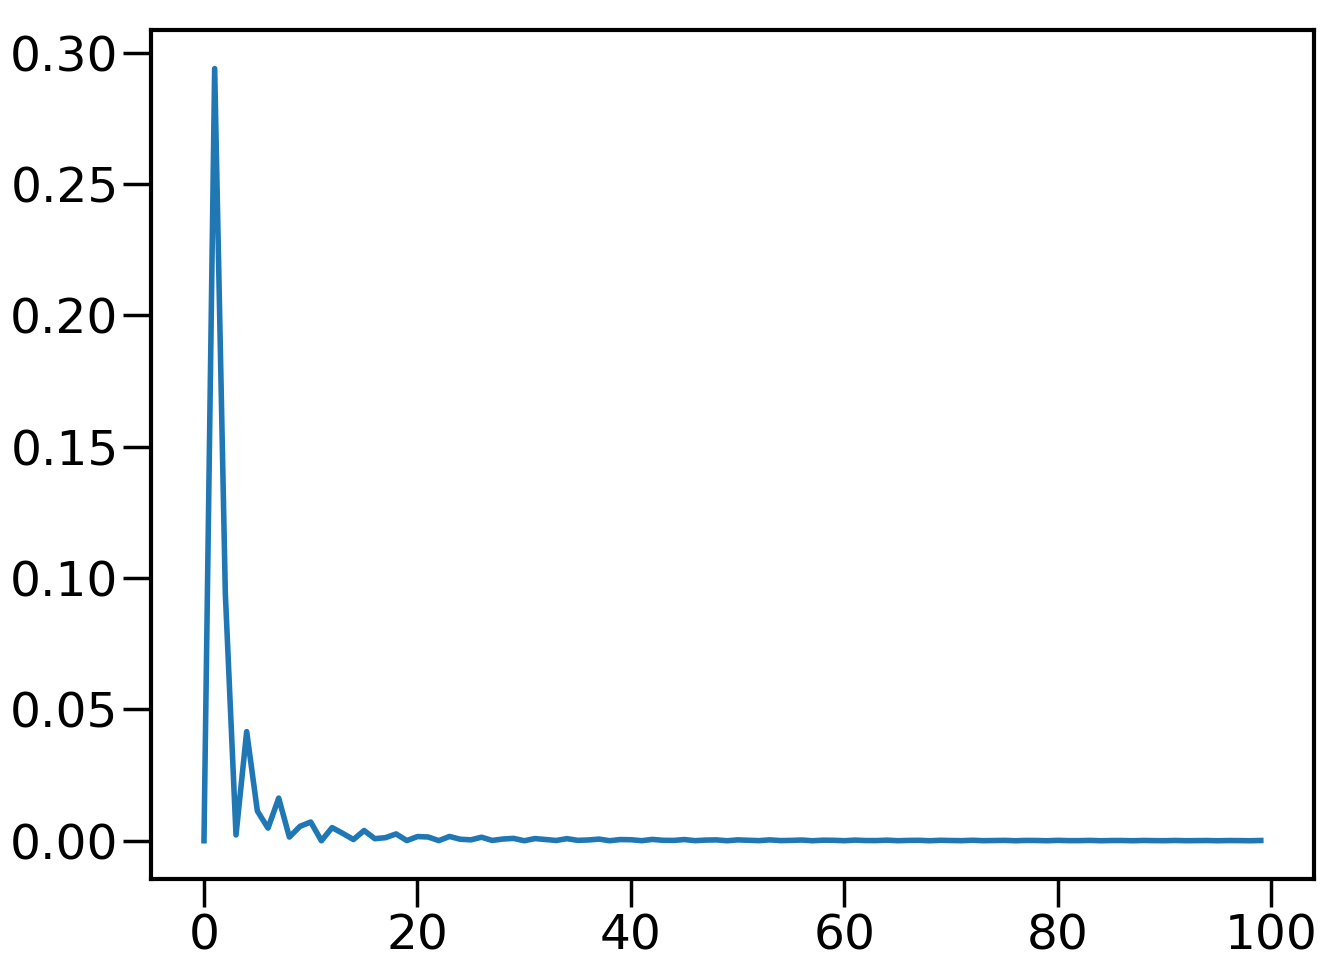

In [23]:
plot(kappa0.cov_utils.window_l,kappa0.cov_utils.Win*(kappa0.cov_utils.window_l*2))

/usr/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
11:23:39 DEBUG:findfont: Matching :family=STIXGeneral:style=normal:variant=normal:weight=normal:stretch=normal:size=35.0 to STIXGeneral ('/usr/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneral.ttf') with score of 0.050000
11:23:39 DEBUG:findfont: Matching :family=STIXGeneral:style=italic:variant=normal:weight=normal:stretch=normal:size=35.0 to STIXGeneral ('/usr/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneralItalic.ttf') with score of 0.050000
11:23:39 DEBUG:findfont: Matching :family=STIXGeneral:style=normal:variant=normal:weight=bold:stretch=normal:size=35.0 to STIXGeneral ('/usr/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneralBol.ttf') with score of 0.000000
11:23:39 DEBUG:findfont: Matching :family=STIXNonUnicode:style=no

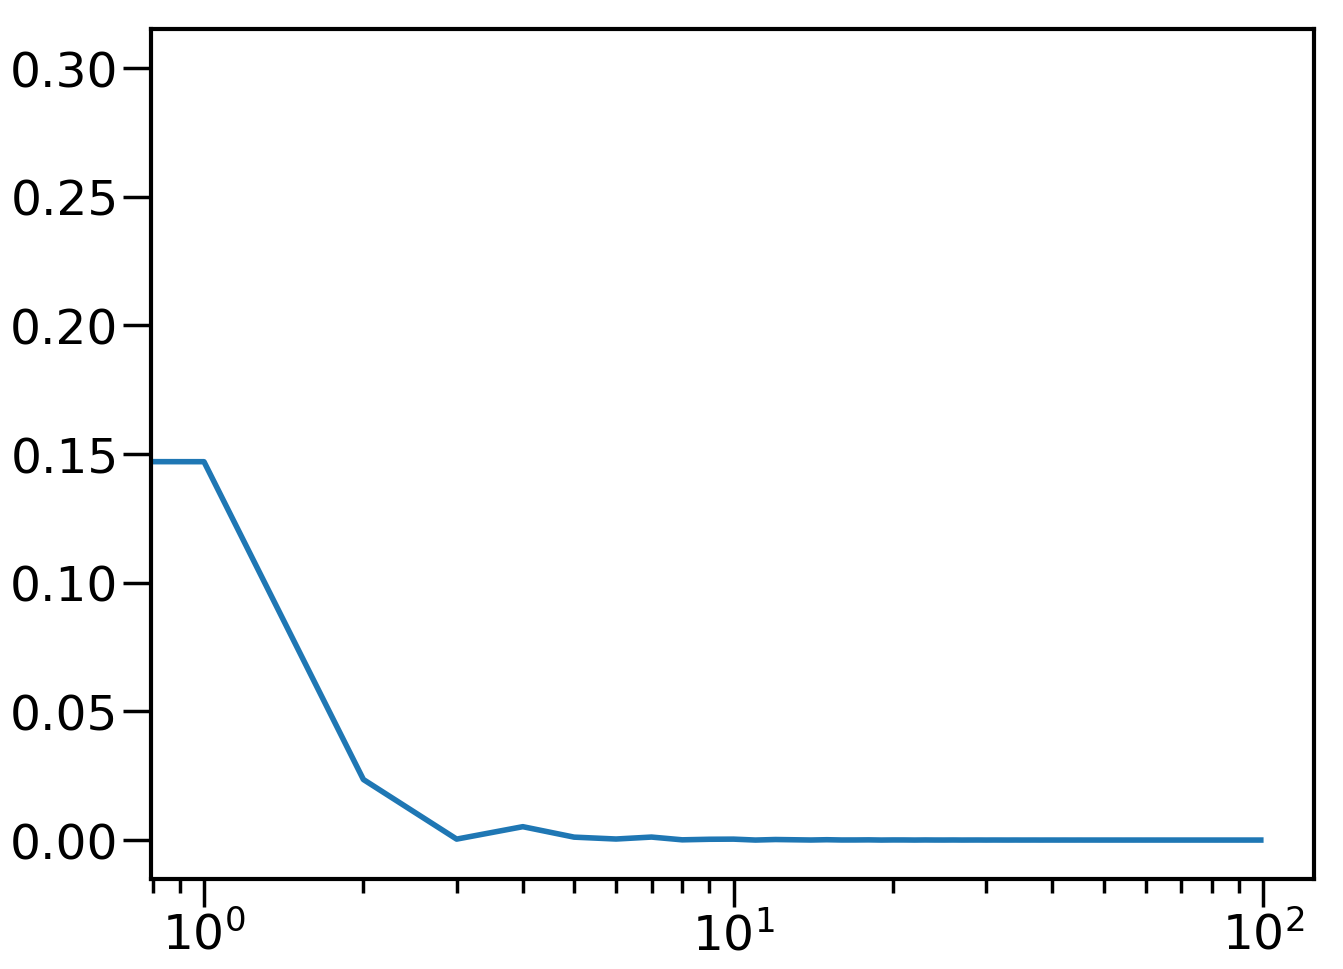

In [24]:
# plot(kappa0.l,kappa0.cov_utils.Win0)
plot(kappa0.cov_utils.window_l,kappa0.cov_utils.Win)
xscale('log')
# yscale('log')

In [25]:
#again get Cl and cov, this time by referencing the particular bin
cl0={}
cl1={}
corr=('shear','shear')
%time cl0['cl0']=cl0G['cl'][corr][(0,0)].compute()
%time cl0['cl']=cl0G['cl_b'][corr][(0,0)].compute()
%time cl0['cov']=cl0G['cov'][corr+corr][(0,0,0,0)].compute()#kappa0.compute_cov_tomo(cl0G['cov'])
%time cl1['cl']=cl1G['cl_b'][corr][(0,0)].compute()
%time cl1['cov']=cl1G['cov'][corr+corr][(0,0,0,0)].compute()#kappa1.compute_cov_tomo(cl1G['cov'])

CPU times: user 16.6 ms, sys: 1e+03 ns, total: 16.6 ms
Wall time: 14.2 ms
CPU times: user 19.8 ms, sys: 6.53 ms, total: 26.3 ms
Wall time: 36.7 ms
CPU times: user 542 ms, sys: 16.4 ms, total: 559 ms
Wall time: 528 ms
CPU times: user 26.7 ms, sys: 46 µs, total: 26.8 ms
Wall time: 33.9 ms
CPU times: user 66.4 ms, sys: 10 µs, total: 66.4 ms
Wall time: 68.9 ms


In [26]:
pars = camb.CAMBparams()
h=cosmo_params['h']
pars.set_cosmology(H0=h*100, ombh2=cosmo_params['Omb']*h*h, omch2=cosmo_params['Omd']*h*h)
pars.InitPower.set_params(As=cosmo_params['As'], ns=cosmo_params['ns'])
pars.set_for_lmax(2000, lens_potential_accuracy=1)

results = camb.get_results(pars)
camb_cl = results.get_lens_potential_cls(lmax=2000)
# plt.loglog(np.arange(2001), cl[:,0])

# plt.ylabel('$[L(L+1)]^2C_L^{\phi\phi}/2\pi$')
# plt.xlabel('$L$')
# plt.xlim([2,2000]);

In [27]:
cl2=np.genfromtxt('/home/deep/repos/kappa_cl_cmb_ccl.dat',names=('l','cl'))

Text(0,0.5,'$C_\\ell$')

/usr/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


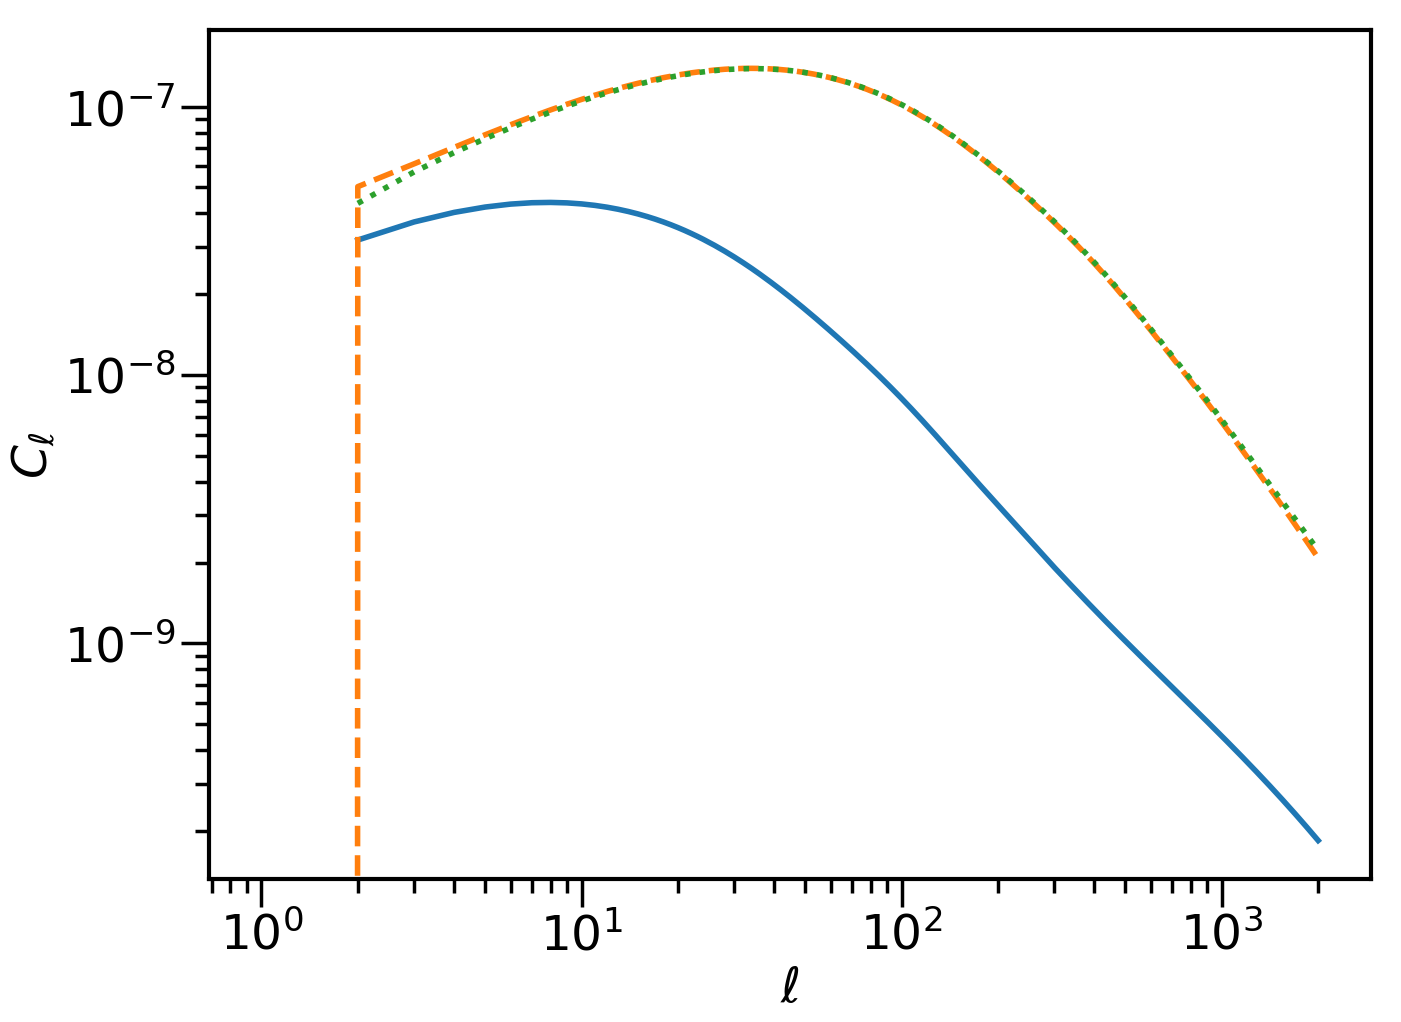

In [28]:
cl_t=cl0['cl0']#[(0,0)]
plot(np.arange(len(cl_t))+2,cl_t)
plot(np.arange(2001), camb_cl[:,0],'--')
plot(cl2['l'],cl2['cl']/1.6,':')
# hlines(1,1,2000)
xscale('log')
yscale('log')
xlabel('$\ell$')
ylabel('$C_\ell$')

/usr/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


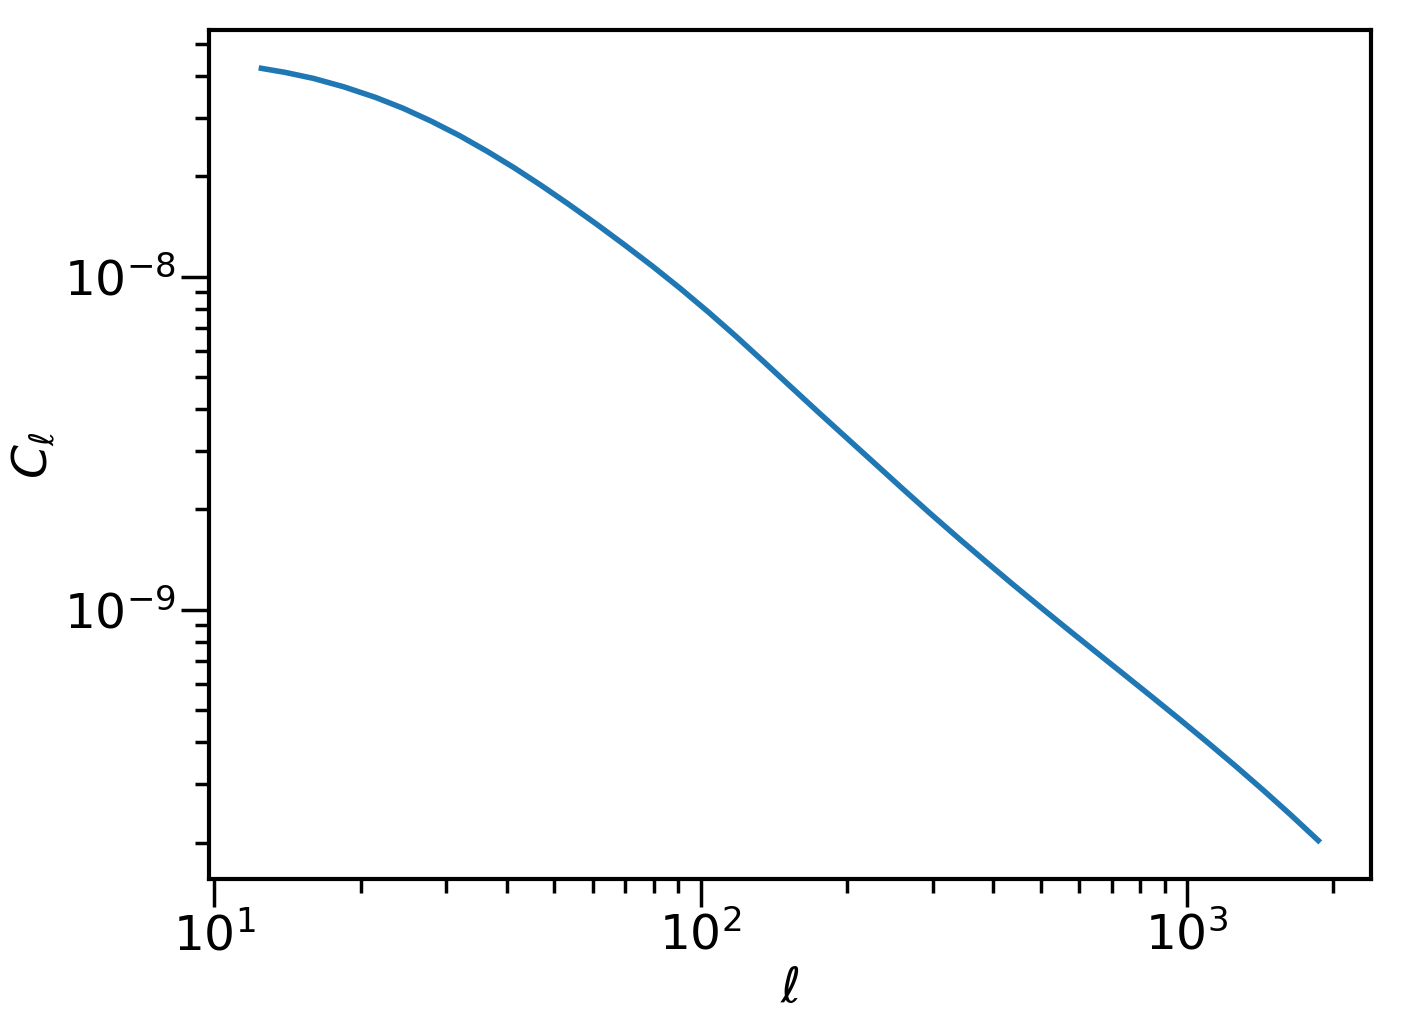

Text(0,0.5,'$C_\\ell$ Ratio')

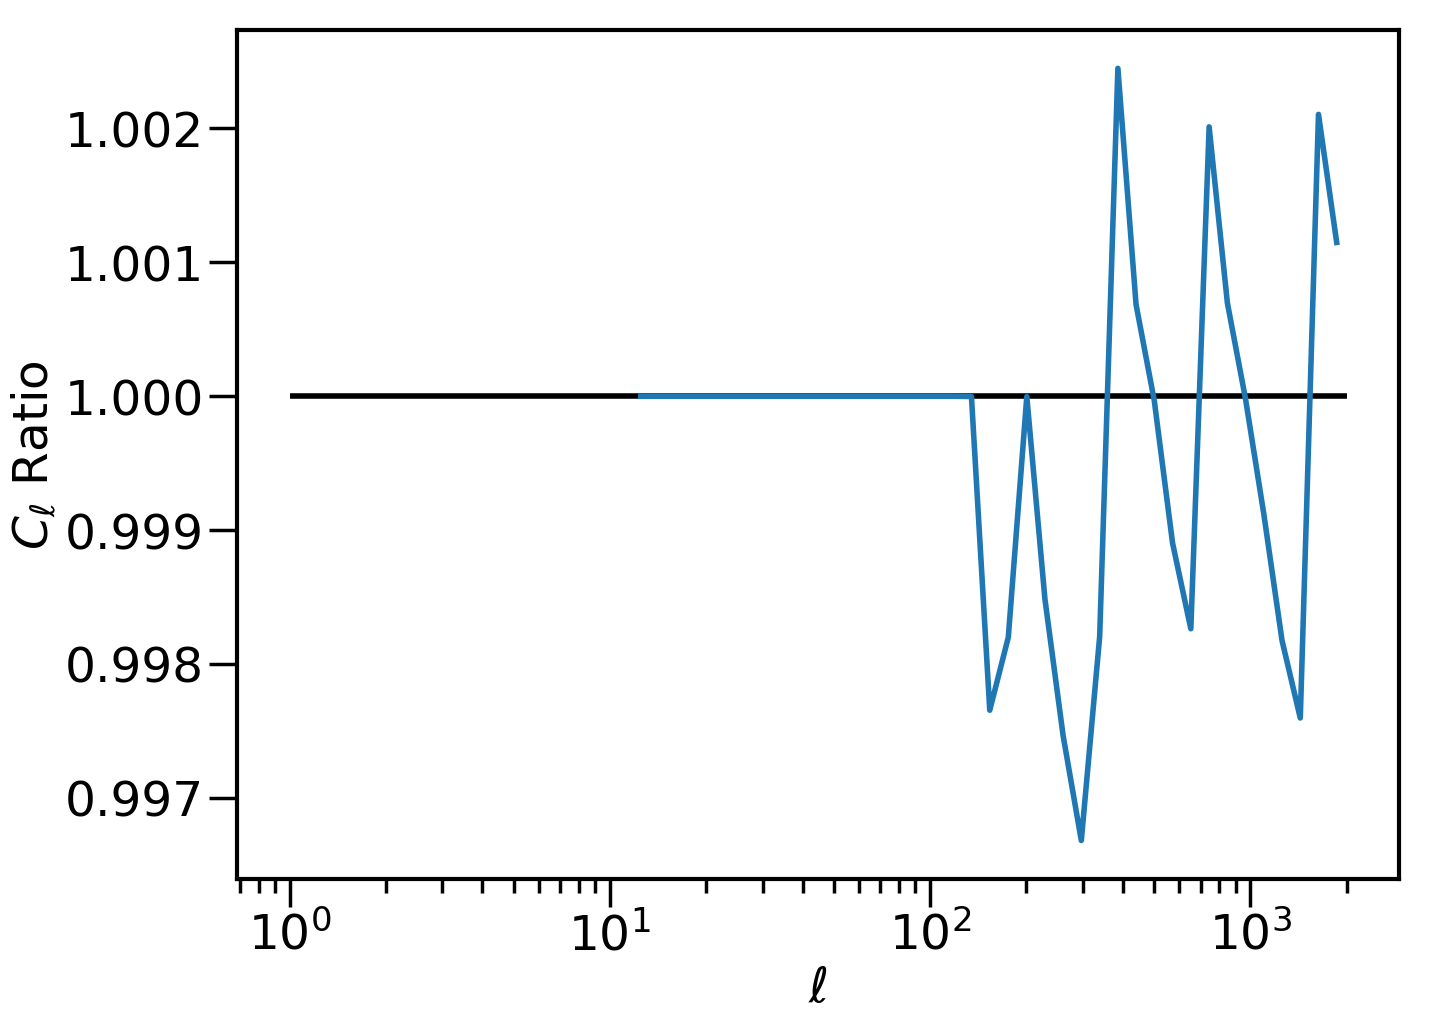

In [29]:
cl_t=cl0['cl']#[(0,0)]
cl_t2=cl1['cl']#[(0,0)]
plot(lb,cl_t)
# hlines(1,1,2000)
xscale('log')
yscale('log')
xlabel('$\ell$')
ylabel('$C_\ell$')

show()
plot(lb,cl_t/cl_t2)
hlines(1,1,2000)
xscale('log')
xlabel('$\ell$')
ylabel('$C_\ell$ Ratio')
# ylim(8e-7,8.6e-7)
# yscale('log')

/usr/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


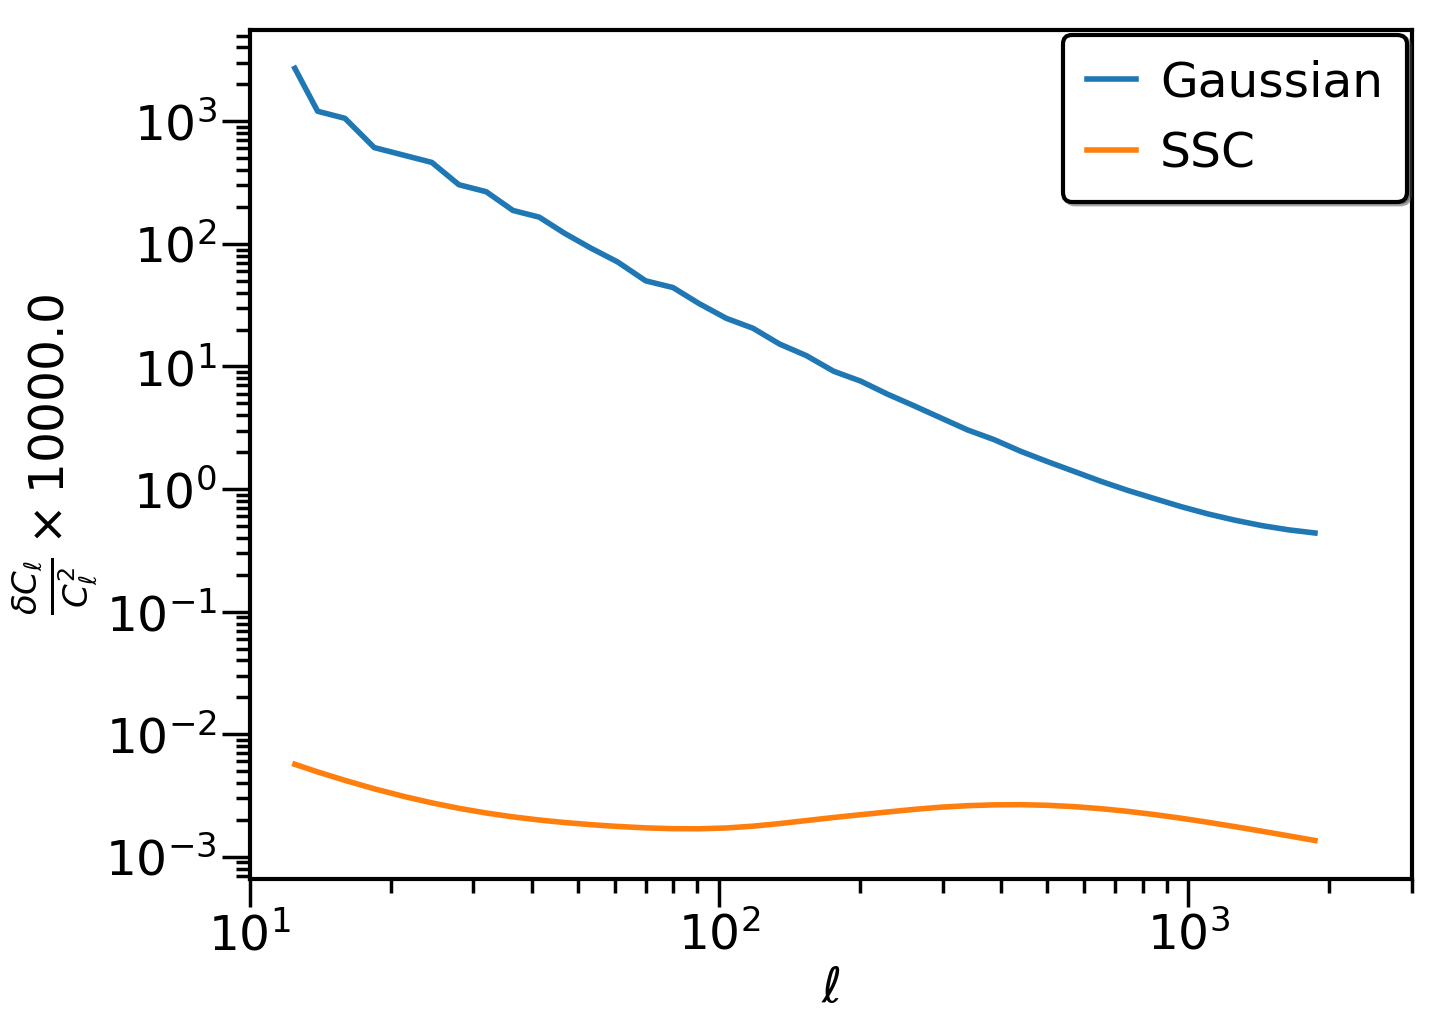

In [30]:
cov0=cl0['cov']#[(0,0,0,0)]
f=1e4
plot(lb,np.diag(cov0['G'])/cl_t**2*f,label='Gaussian')
#plot(lb,np.diag(cov02['G'])/cl_t**2*f*0.95)
plot(lb,np.diag(cov0['SSC'])/cl_t**2*f,label='SSC')
# plot(lb,np.diag(cov0['SSC_dk'])/cl_t**2*f)
xscale('log')
yscale('log')
xlim(10,3000)
xlabel(r'$\ell$')
ylabel(r'$\frac{\delta C_\ell}{C_\ell^2}\times'+str(f)+'$')
legend()

Text(0,0.5,'$\\ell$')

/usr/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


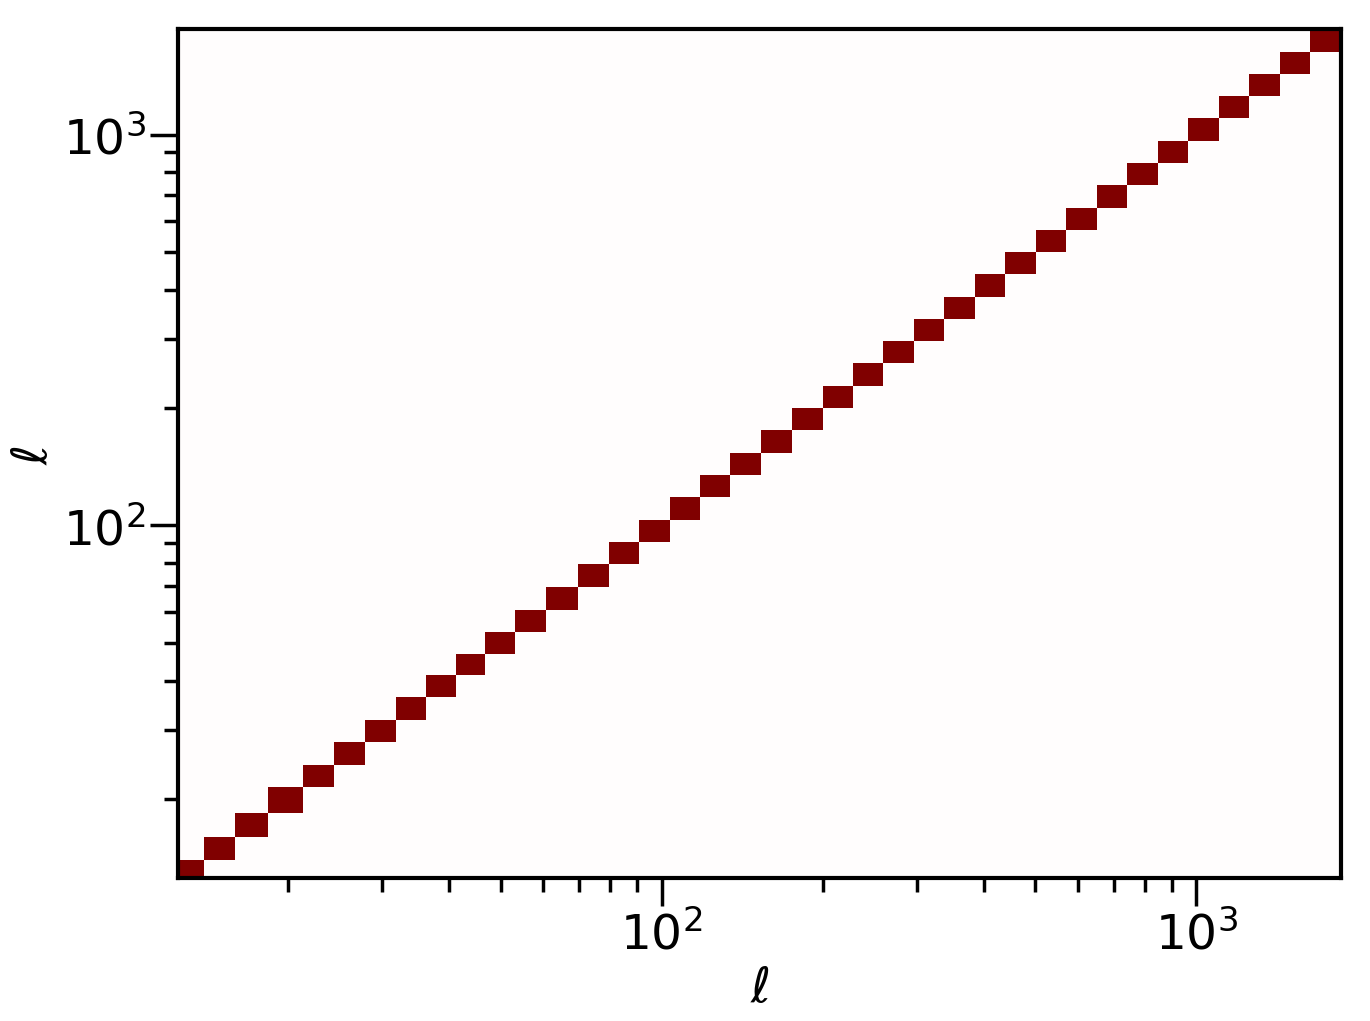

In [31]:
cov0=cl0['cov']#[(0,0,0,0)]
corr2=kappa0.cov_utils.corr_matrix(cov0['final'])
pcolor(lb,lb,corr2,vmin=-1,vmax=1,cmap='seismic')
xscale('log')
yscale('log')
# xlim(lmin_clB,lmax_clB)
# ylim(lmin_clB,lmax_clB)
xlabel(r'$\ell$')
ylabel(r'$\ell$')

##  Test with multiple redshift bins (Tomography)

In [32]:
#Setup redshift bins
zmin=0.3
zmax=2

z=np.linspace(0,5,200)
pzs=lsst_pz_source(z=z)
x=z<zmax
x*=z>zmin
z=z[x]
pzs=pzs[x]

ns0=26. #ns=inf means shape noise is zero
nbins=1  # Number of tomographic bins
z_sigma=0.01
zs_bins=source_tomo_bins(zp=z,p_zp=pzs,ns=ns0,nz_bins=nbins,
                         ztrue_func=ztrue_given_pz_Gaussian,zp_bias=np.zeros_like(z),
                        zp_sigma=z_sigma*np.ones_like(z))
zs_bins=zs_bin1
# nbins=np.int(nbins*(nbins+1.)/2.)
# zl_bins=lens_wt_tomo_bins(zp=z,p_zp=pzs,ns=ns0,nz_bins=nbins,z_bins=np.linspace(zmin,1.5,nbins),
#                           ztrue_func=ztrue_given_pz_Gaussian,zp_bias=np.zeros_like(z),
#                         zp_sigma=z_sigma*np.ones_like(z))

do_cov=True
bin_cl=True
SSV_cov=True
tidal_SSV=False
do_sample_variance=True
use_window=False

/usr/lib/python3.7/site-packages/astropy/units/quantity.py:639: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


In [33]:
kappaS = cov_3X2(zs_bins=zs_bins,l=l0,do_cov=do_cov,bin_cl=bin_cl,l_bins=l_bins,zg_bins=None,
               SSV_cov=SSV_cov,tidal_SSV_cov=tidal_SSV,do_xi=False,use_window=use_window,
                 do_sample_variance=do_sample_variance,
               bin_xi=bin_xi)#ns=np.inf)

# kappaL = Kappa(zs_bins=zl_bins,l=l0,cross_PS=False,do_cov=do_cov,bin_cl=bin_cl,l_bins=l_bins,
#                stack_data=stack_data,SSV_cov=SSV_cov,tidal_SSV_cov=tidal_SSV,do_xi=do_xi,bin_xi=bin_xi,theta_bins=th_bins)#ns=np.inf)

In [34]:
%time clSG=kappaS.cl_tomo()
kappaS.SN,kappa0.SN

CPU times: user 17.7 s, sys: 94 ms, total: 17.8 s
Wall time: 7.84 s


({('shear', 'shear'): array([[[2.92901365e-10]]])},
 {('shear', 'shear'): array([[[2.92901365e-10]]])})

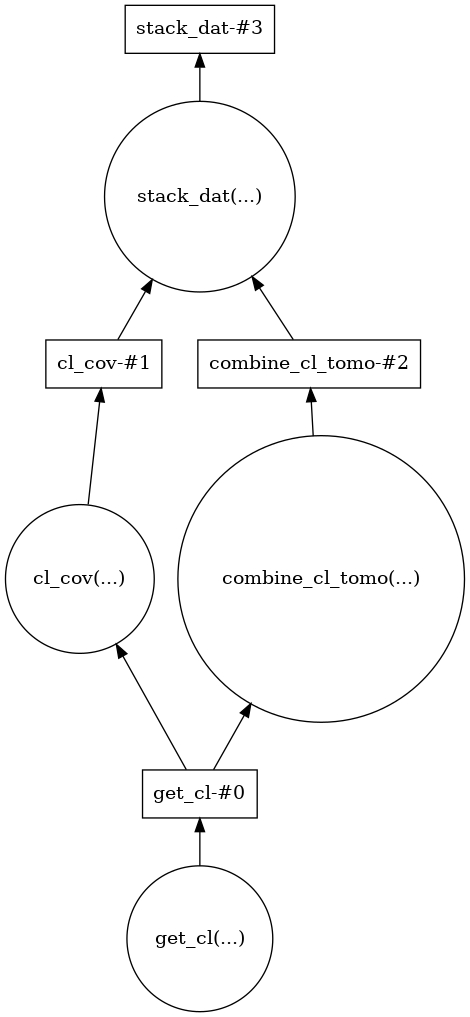

In [35]:
clSG['stack'].visualize() #compute graph

In [36]:
%time clS=clSG['stack'].compute()

CPU times: user 530 ms, sys: 36.4 ms, total: 567 ms
Wall time: 537 ms


In [37]:
# np.diag(kappaL.lensing_utils.SN[0]),
np.diag(kappaS.lensing_utils.SN[0])

array([2.92901365e-10])

In [38]:
covS_inv=np.linalg.inv(clS['cov'])
print (np.sqrt(np.dot(clS['cl'],np.dot(covS_inv,clS['cl']))))


425.6106553055373


/usr/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


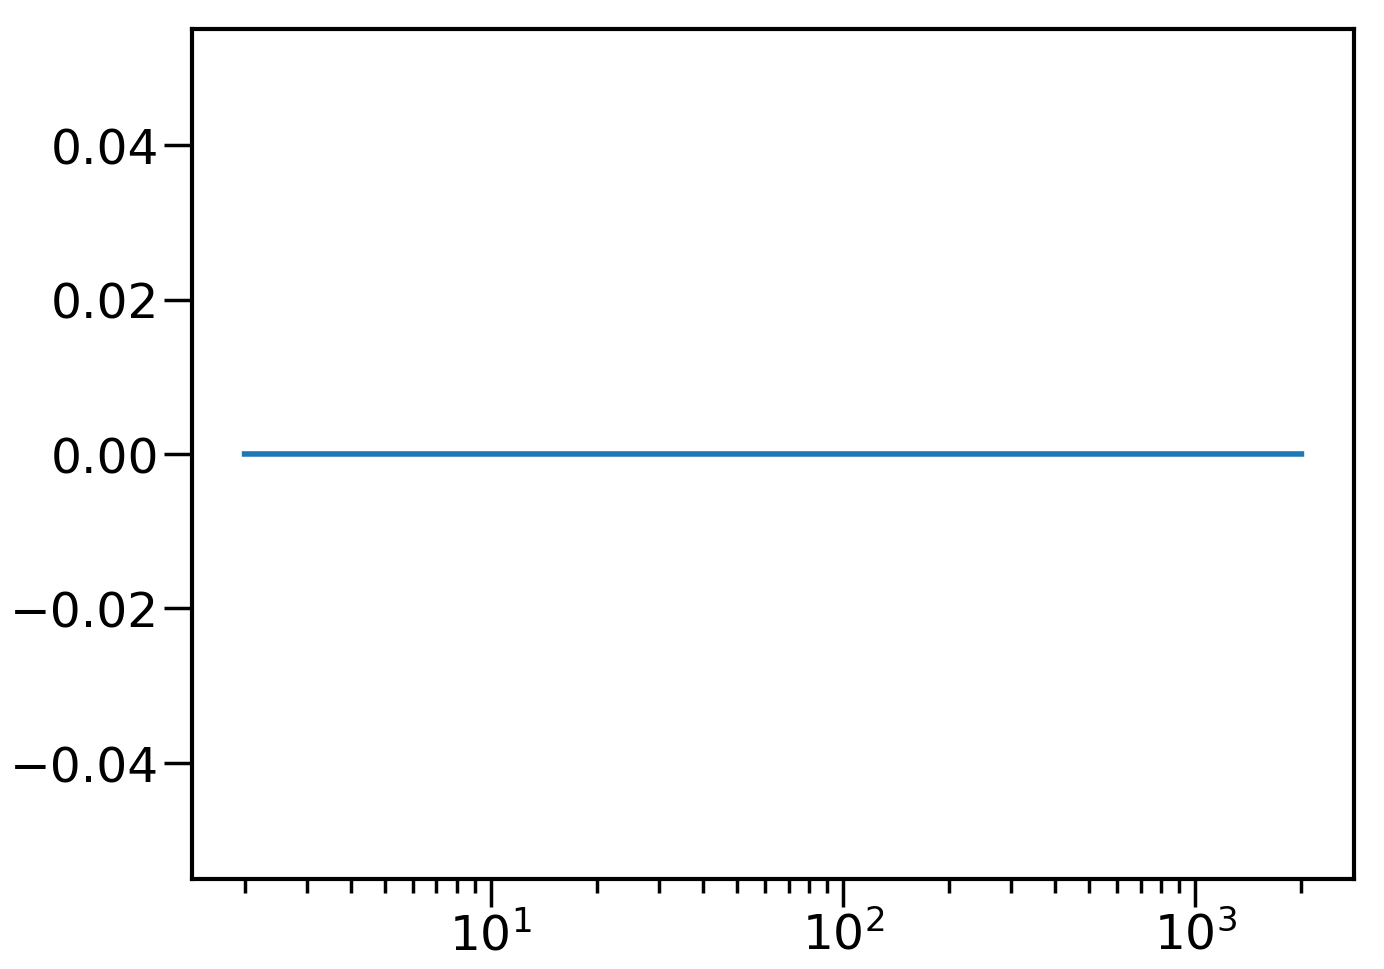

In [39]:
plot(kappaS.l,kappaS.cov_utils.Win)
xscale('log')

Text(0,0.5,'$p(z)$')

/usr/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


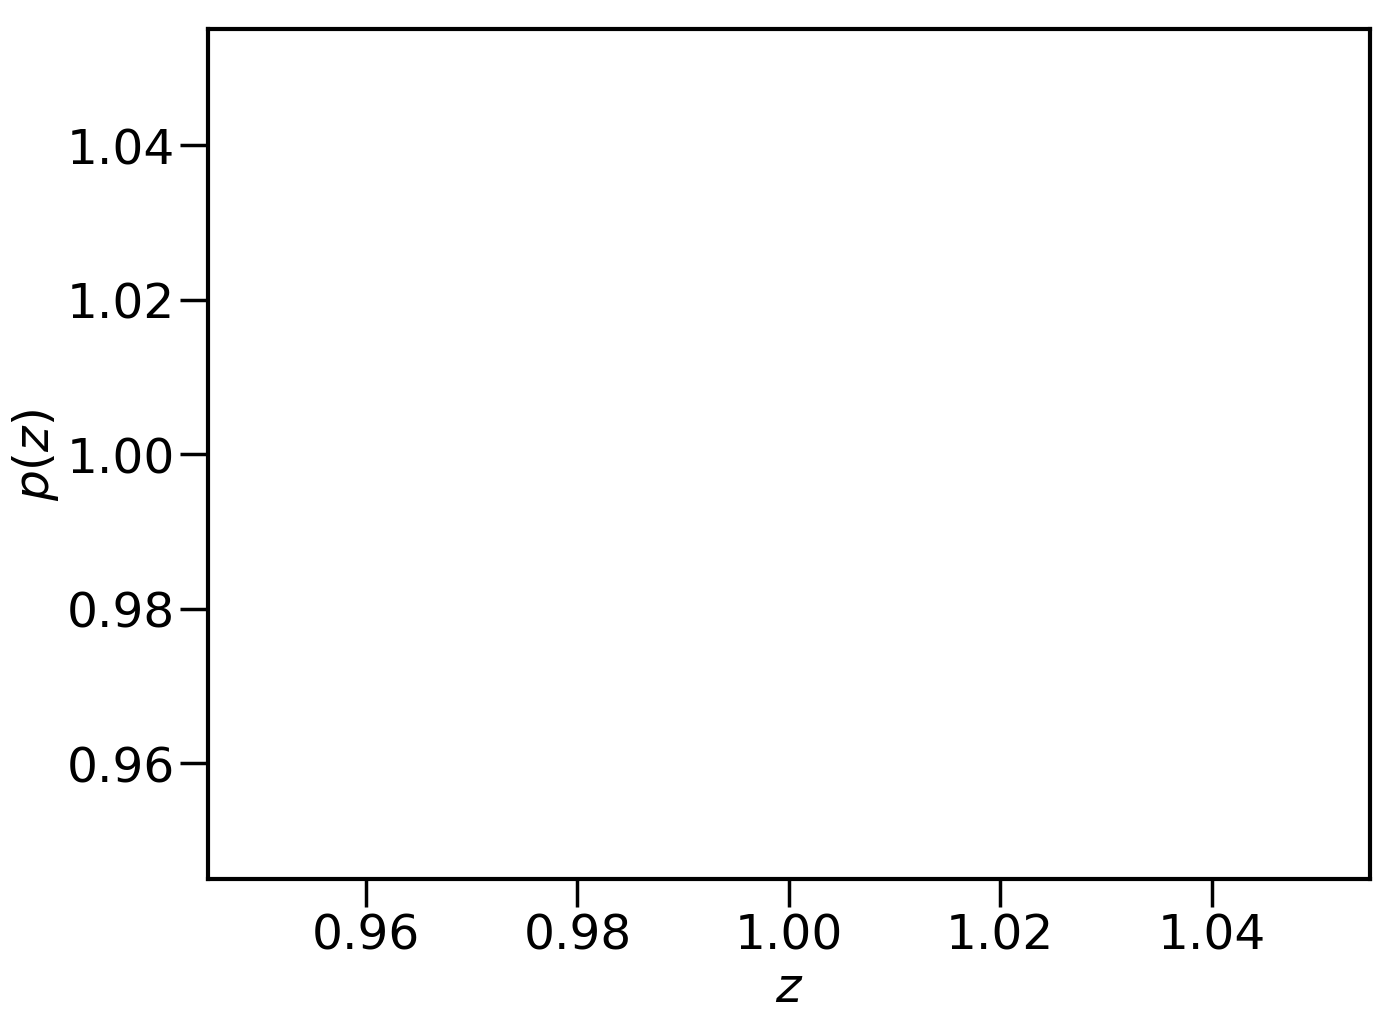

In [40]:
nb=kappaS.z_bins['shear']['n_bins']
for i in np.arange(nb):
    zb=zs_bins[i] #kappaS.zs_bins[i]
    plot(zb['z'],zb['pz'])
#     print(np.sum(zb['nz']))
xlabel(r'$z$')
ylabel(r'$p(z)$')

Text(0,0.5,'Lensing Kernel')

/usr/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


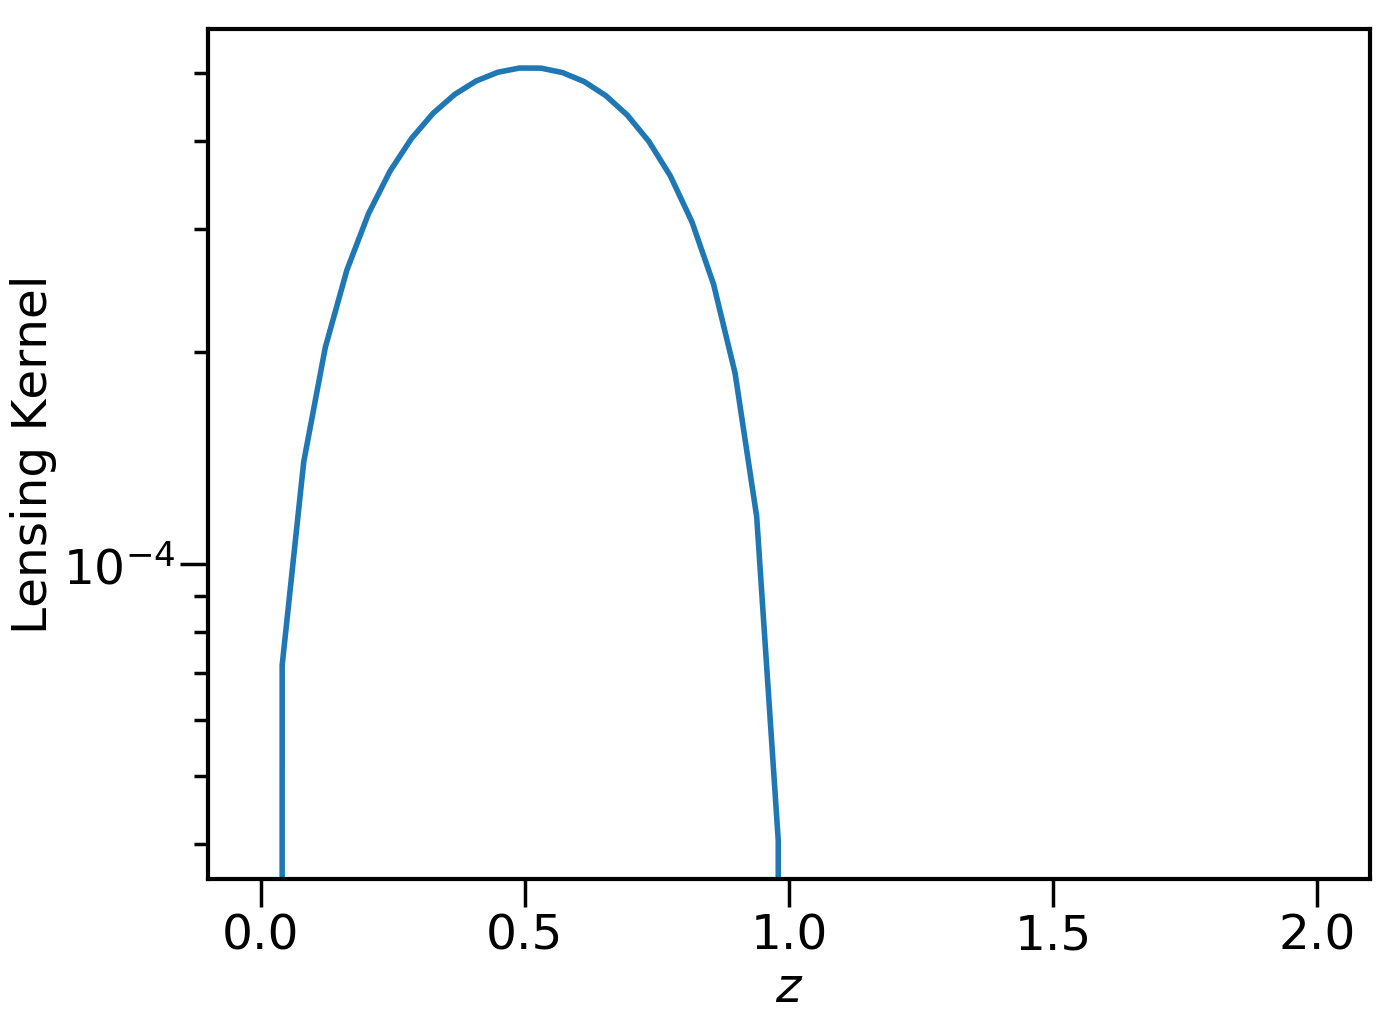

In [41]:
nb=kappaS.z_bins['shear']['n_bins']
zl=kappaS.z_bins['shear']['z_lens_kernel']
for i in np.arange(nb):
    zb=kappaS.z_bins['shear'][i]
    plot(zl,zb['lens_kernel'])
#     print(np.sum(zb['nz']))
#     print(zb['z'],zb['pz'])
yscale('log')
xlabel(r'$z$')
ylabel(r'Lensing Kernel')
# ylim(2.e-4,20)

In [42]:
clS['cov']/cl0['cov']['final']

array([[0.9999979 , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.99999592, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.99999602, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.99678547, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.99680839,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.99689779]])

/usr/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


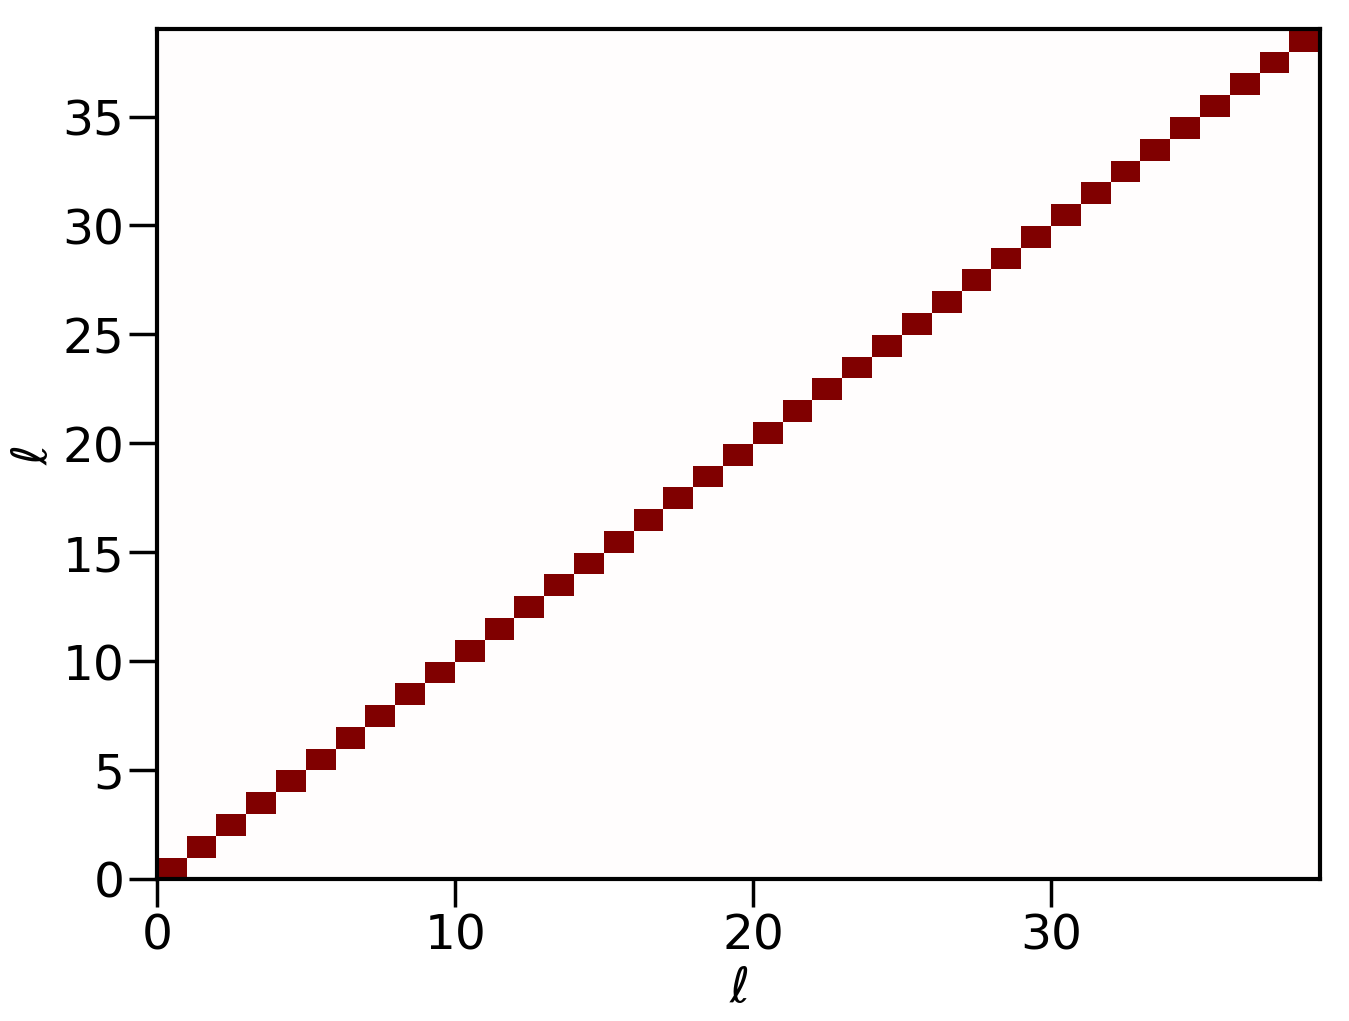

In [43]:
cc=kappaS.cov_utils
corrS=cc.corr_matrix(clS['cov'])
pcolor(corrS,vmin=-1,vmax=1,cmap='seismic')
xlabel(r'$\ell$')
ylabel(r'$\ell$')
show()
# corrL=cc.corr_matrix(clL['cov'])
# pcolor(corrL,vmin=-1,vmax=1,cmap='seismic')

In [44]:
corr=('shear','shear')

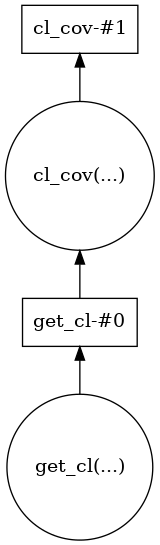

In [46]:
clSG['cov'][corr+corr][(0,0,0,0)].visualize() #graph for 1 covariance

# Lensing X Lensing Correlation function covariance

##  Test with multiple redshift bins (Tomography)

In [57]:
from importlib import reload
import cov_utils
reload(cov_utils)
from cov_utils import *

In [58]:
import cov_3X2
reload(cov_3X2)
from cov_3X2 import *
from wigner_transform import *

In [59]:
import hankel_transform
reload(hankel_transform)
from hankel_transform import *

In [60]:
#Setup redshift bins
zmin=0.3
zmax=2

z=np.linspace(0,5,200)
pzs=lsst_pz_source(z=z)
x=z<zmax
x*=z>zmin
z=z[x]
pzs=pzs[x]

ns0=26 #26+np.inf #ns=inf means shape noise is zero
nbins=3  # Number of tomographic bins
z_sigma=0.01
zs_bins=source_tomo_bins(zp=z,p_zp=pzs,ns=ns0,nz_bins=nbins,
                         ztrue_func=ztrue_given_pz_Gaussian,zp_bias=np.zeros_like(z),
                        zp_sigma=z_sigma*np.ones_like(z))

# nbins=np.int(nbins*(nbins+1.)/2.)
# zl_bins=lens_wt_tomo_bins(zp=z,p_zp=pzs,ns=ns0,nz_bins=nbins,z_bins=np.linspace(zmin,1.5,nbins),
#                           ztrue_func=ztrue_given_pz_Gaussian,zp_bias=np.zeros_like(z),
#                         zp_sigma=z_sigma*np.ones_like(z))

do_cov=True
SSV_cov=False
tidal_SSV=False

/usr/lib/python3.7/site-packages/astropy/units/quantity.py:639: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


In [61]:
np.sum(zs_bins[0]['pzdz'])

0.9999999999999996

In [62]:
do_xi=True
bin_xi=True
bin_cl=False
th_min=1./60
th_max=10
n_th_bins=10
th_bins=np.logspace(np.log10(th_min*2),np.log10(th_max),n_th_bins+1)
th=np.logspace(np.log10(th_min*2),np.log10(th_max),n_th_bins*10)
thb=0.5*(th_bins[1:]+th_bins[:-1])

In [69]:
#Hankel Transform setup
l_max=1e4
l_min=2
prune_theta=2
HT_kwargs={'l_min':l_min,  'l_max':l_max,
                        'theta_min':th_min*d2r*.9, 'theta_max':th_max*d2r,
                        'n_zeros':40000, 'prune_theta':prune_theta, 'm1_m2':[(2,2),(2,-2),(0,0)]}
# %time HT=hankel_transform(**HT_kwargs)
# HT_kwargs2={'l_min':l_min,  'l_max':l_max,
#                         'theta_min':th_min*d2r*.9, 'theta_max':th_max*d2r,
#                         'n_zeros':40000, 'prune_theta':2, 'm1_m2':[(2,-2)]}#,(2,-2)]}

In [70]:
np.sum(zs_bins[0]['pzdz'])

0.9999999999999996

In [71]:
bin_xi=True

In [72]:
#use redshift bins from power spectrum part
XI_H =cov_3X2(zs_bins=zs_bins,l=l0,do_cov=do_cov,bin_cl=bin_cl,l_bins=l_bins,zg_bins=None,
               SSV_cov=SSV_cov,tidal_SSV_cov=tidal_SSV,do_xi=True,HT_kwargs=HT_kwargs,
               bin_xi=bin_xi,theta_bins=th_bins)#ns=np.inf)
# XI_H2 = lensing_lensing(zs_bins=zs_bins,l=l0,do_cov=do_cov,bin_cl=bin_cl,l_bins=l_bins,
#                SSV_cov=SSV_cov,tidal_SSV_cov=tidal_SSV,do_xi=True,HT_kwargs=HT_kwargs2,
#                bin_xi=bin_xi,theta_bins=th_bins)#ns=np.inf)

11:29:48 WARNING:cross covariance not implemented with Hankel Transform. m1_m2s: [(2, 2), (2, -2), (0, 0)]
11:29:48 INFO:pruning theta, log_space:True n_f:2
11:29:48 INFO:pruned theta:157
11:29:48 INFO:nr:156
11:29:50 INFO:changed l_max to 28985.33299980642 to cover theta_min. j_nu=4
11:29:50 INFO:pruning theta, log_space:True n_f:2
11:29:50 INFO:pruned theta:403
11:29:50 INFO:nr:403
11:29:55 INFO:pruning theta, log_space:True n_f:2
11:29:55 INFO:pruned theta:157
11:29:55 INFO:nr:156


In [74]:
# Wigner Transform setup
l_W=np.arange(2,l_max,dtype='int')
l0=l_W
l_bins=None
WT_kwargs={'l':l_W ,'theta': th*d2r,'m1_m2':[(2,2),(2,-2),(0,0)]}
# if not 'WT' in globals():
%time WT=wigner_transform(**WT_kwargs)

XI_W= cov_3X2(zs_bins=zs_bins,l=l0,do_cov=do_cov,bin_cl=bin_cl,l_bins=l_bins,zg_bins=None,
               SSV_cov=SSV_cov,tidal_SSV_cov=tidal_SSV,do_xi=True,HT=WT,
               bin_xi=bin_xi,theta_bins=th_bins)#ns=np.inf)

CPU times: user 464 ms, sys: 849 ms, total: 1.31 s
Wall time: 9.6 s


Process ForkPoolWorker-123:
Process ForkPoolWorker-114:
Process ForkPoolWorker-109:
Process ForkPoolWorker-107:
Process ForkPoolWorker-115:
Process ForkPoolWorker-105:
Process ForkPoolWorker-120:
Process ForkPoolWorker-122:
Process ForkPoolWorker-106:
Process ForkPoolWorker-121:
Process ForkPoolWorker-119:
Process ForkPoolWorker-141:
Process ForkPoolWorker-108:
Process ForkPoolWorker-138:
Process ForkPoolWorker-129:
Process ForkPoolWorker-125:
Process ForkPoolWorker-142:
Process ForkPoolWorker-124:
Process ForkPoolWorker-104:
Process ForkPoolWorker-127:
Process ForkPoolWorker-101:
Process ForkPoolWorker-143:
Traceback (most recent call last):
Process ForkPoolWorker-134:
Process ForkPoolWorker-136:
Process ForkPoolWorker-128:
Process ForkPoolWorker-97:
Traceback (most recent call last):
Process ForkPoolWorker-139:
Process ForkPoolWorker-144:
Traceback (most recent call last):
Process ForkPoolWorker-110:
Traceback (most recent call last):
Process ForkPoolWorker-132:
Process ForkPoolWorke

In [75]:
# Wigner Transform setup... Using high ell to test convergence
WT_L_kwargs={'l': np.arange(2,l_max*2,dtype='int'),'theta': th*d2r,'m1_m2':[(2,2),(2,-2),(0,0)]}
# if (not 'WT_L' in globals()):
%time WT_L=wigner_transform(**WT_L_kwargs)

XI_W_L= cov_3X2(zs_bins=zs_bins,l=l0,do_cov=do_cov,bin_cl=bin_cl,l_bins=l_bins,zg_bins=None,
               SSV_cov=SSV_cov,tidal_SSV_cov=tidal_SSV,do_xi=True,HT=WT_L,
               bin_xi=bin_xi,theta_bins=th_bins)#ns=np.inf)

CPU times: user 754 ms, sys: 1.07 s, total: 1.82 s
Wall time: 11.4 s


Process ForkPoolWorker-167:
Process ForkPoolWorker-179:
Process ForkPoolWorker-169:
Process ForkPoolWorker-176:
Process ForkPoolWorker-165:
Process ForkPoolWorker-183:
Process ForkPoolWorker-157:
Process ForkPoolWorker-166:
Process ForkPoolWorker-158:
Process ForkPoolWorker-168:
Process ForkPoolWorker-173:
Process ForkPoolWorker-155:
Process ForkPoolWorker-178:
Process ForkPoolWorker-163:
Traceback (most recent call last):
Process ForkPoolWorker-182:
Process ForkPoolWorker-145:
Process ForkPoolWorker-147:
Process ForkPoolWorker-186:
Process ForkPoolWorker-191:
Process ForkPoolWorker-187:
Process ForkPoolWorker-184:
Process ForkPoolWorker-164:
Traceback (most recent call last):
Process ForkPoolWorker-181:
Process ForkPoolWorker-154:
Process ForkPoolWorker-170:
Process ForkPoolWorker-190:
Process ForkPoolWorker-185:
Process ForkPoolWorker-152:
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkPoolWorker-151:
Traceback (most recent call last):
Traceback (mo

In [76]:
%time clHG=XI_H.cl_tomo()
# %time xiHG2=XI_H2.xi_tomo()

%time clWG=XI_W.cl_tomo()
%time clWG_L=XI_W_L.cl_tomo()

/usr/lib/python3.7/site-packages/astropy/units/quantity.py:639: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


CPU times: user 9.92 s, sys: 259 ms, total: 10.2 s
Wall time: 5.3 s


/usr/lib/python3.7/site-packages/astropy/units/quantity.py:639: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


CPU times: user 10.3 s, sys: 236 ms, total: 10.5 s
Wall time: 5.35 s


/usr/lib/python3.7/site-packages/astropy/units/quantity.py:639: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


CPU times: user 10.1 s, sys: 167 ms, total: 10.3 s
Wall time: 5.28 s


In [77]:
np.sum(zs_bins[0]['pzdz'])

0.9999999999999996

In [78]:
%time xiHG=XI_H.xi_tomo()
# %time xiHG2=XI_H2.xi_tomo()

%time xiWG=XI_W.xi_tomo()
%time xiWG_L=XI_W_L.xi_tomo()

CPU times: user 28.6 ms, sys: 7.01 ms, total: 35.7 ms
Wall time: 32.7 ms
CPU times: user 41 ms, sys: 49 µs, total: 41.1 ms
Wall time: 37.8 ms
CPU times: user 18.6 ms, sys: 3.34 ms, total: 22 ms
Wall time: 18.9 ms


/usr/lib/python3.7/site-packages/astropy/units/quantity.py:639: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/usr/lib/python3.7/site-packages/astropy/units/quantity.py:639: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/usr/lib/python3.7/site-packages/astropy/units/quantity.py:639: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


In [79]:
%time xiH=xiHG['stack'].compute()
# %time xiH2=xiHG2['stack'].compute()

CPU times: user 3min 56s, sys: 2.36 s, total: 3min 59s
Wall time: 20.9 s


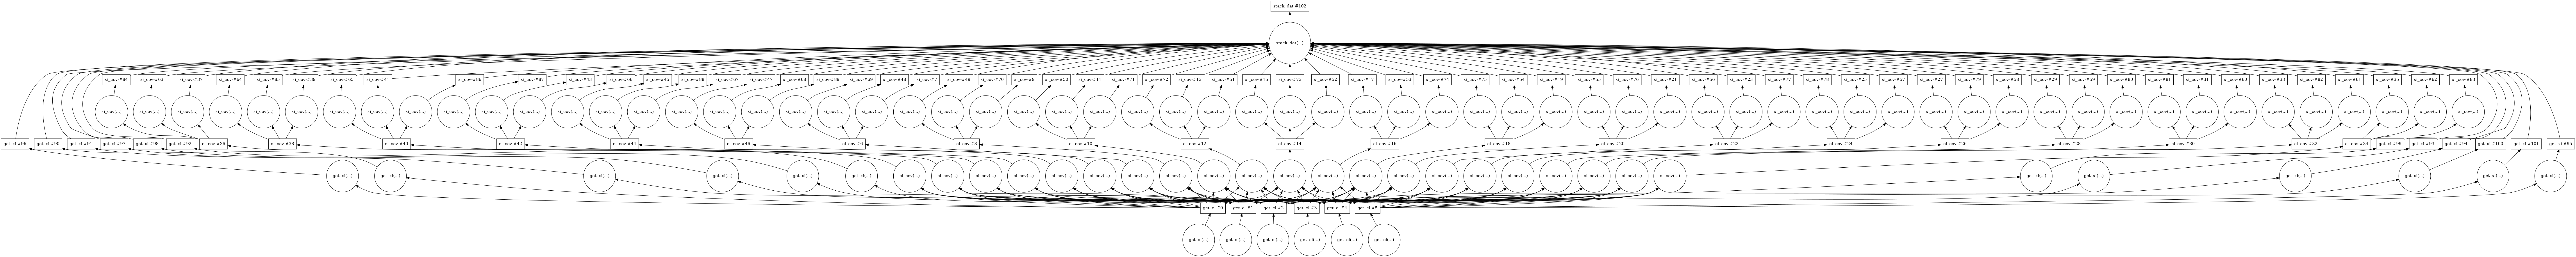

In [80]:
xiHG['stack'].visualize() #compute graph

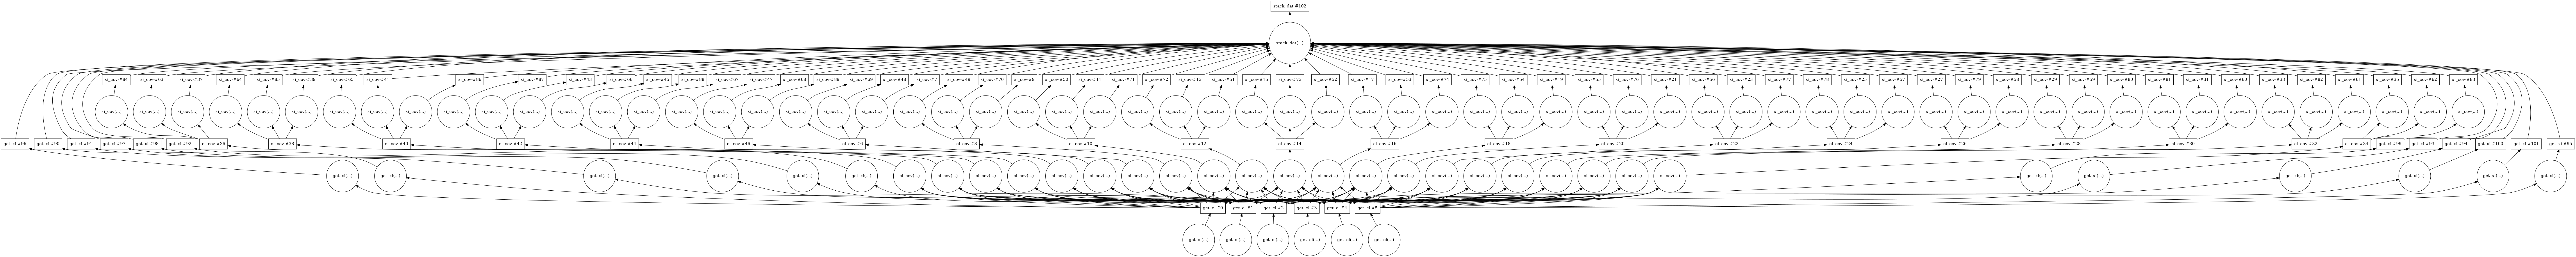

In [81]:
xiWG['stack'].visualize() #compute graph

In [82]:
%time xiW=xiWG['stack'].compute()
%time xiW_L=xiWG_L['stack'].compute()

CPU times: user 24.1 s, sys: 355 ms, total: 24.5 s
Wall time: 2.12 s
CPU times: user 49.7 s, sys: 505 ms, total: 50.2 s
Wall time: 4.09 s


In [83]:
f=1
cov_xiH_inv=np.linalg.inv(xiH['cov']*f)
print (np.sqrt(np.dot(xiH['xi'],np.dot(cov_xiH_inv,xiH['xi']))))

cov_xiW_inv=np.linalg.inv(xiW['cov']*f)
print (np.sqrt(np.dot(xiW['xi'],np.dot(cov_xiW_inv,xiW['xi']))))

cov_xiWL_inv=np.linalg.inv(xiW_L['cov']*f)
print (np.sqrt(np.dot(xiW_L['xi'],np.dot(cov_xiWL_inv,xiW_L['xi']))))

232.3476799891966
133.7230683934058
130.80286636996848


/usr/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
11:33:01 DEBUG:findfont: Matching :family=DejaVu Sans:style=normal:variant=normal:weight=normal:stretch=normal:size=42.0 to DejaVu Sans ('/usr/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000


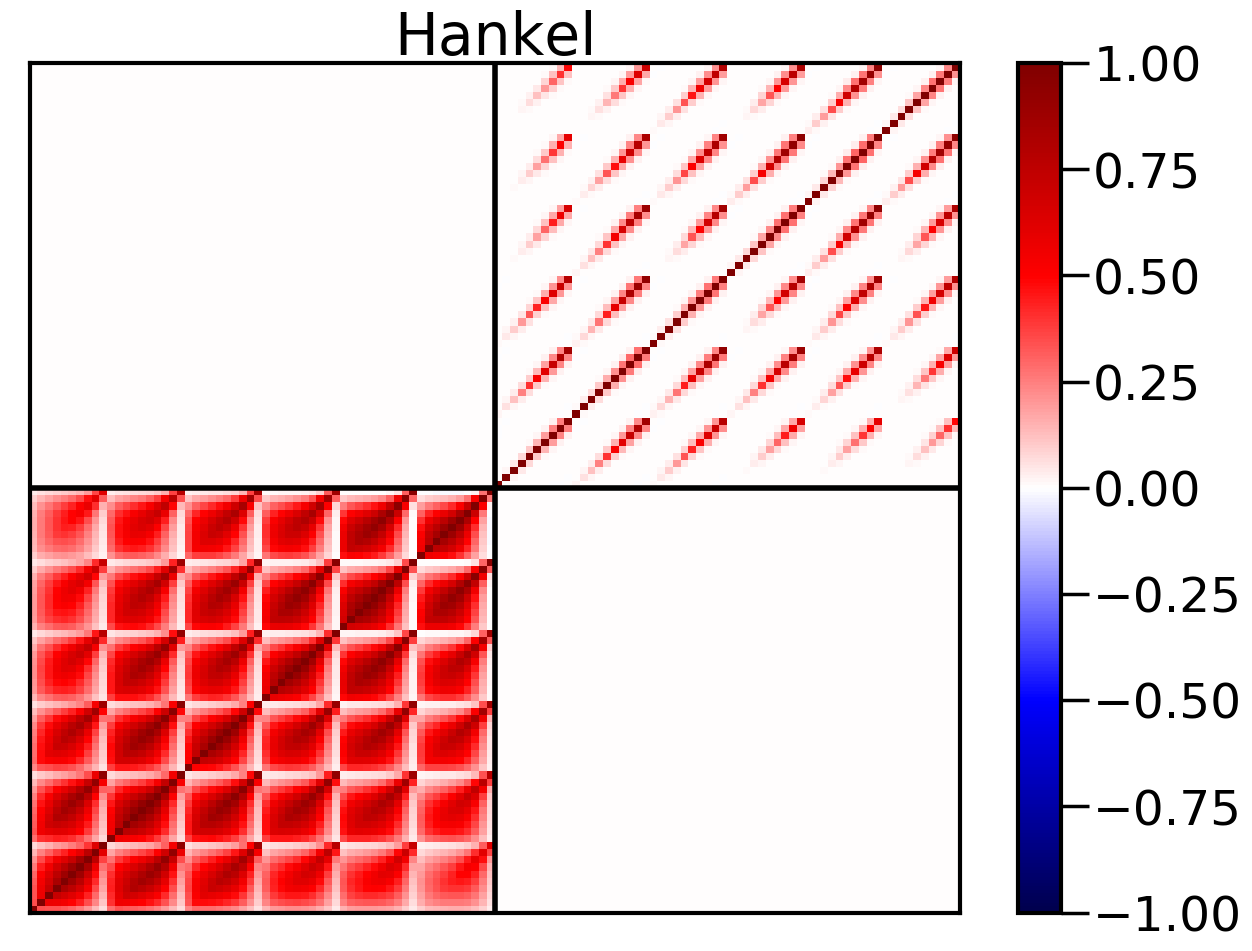

In [84]:
cc=XI_H.cov_utils
corrH=cc.corr_matrix(xiH['cov'])
pcolor(corrH,vmin=-1,vmax=1,cmap='seismic')
# xlabel(r'$\theta$ (degrees)')
# ylabel(r'$\theta$ (degrees)')
title('Hankel')
hlines(60,0,120)
vlines(60,0,120)
xticks([])
yticks([])


colorbar()
show()
# corrL=cc.corr_matrix(clL['cov'])
# pcolor(corrL,vmin=-1,vmax=1,cmap='seismic')

/usr/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


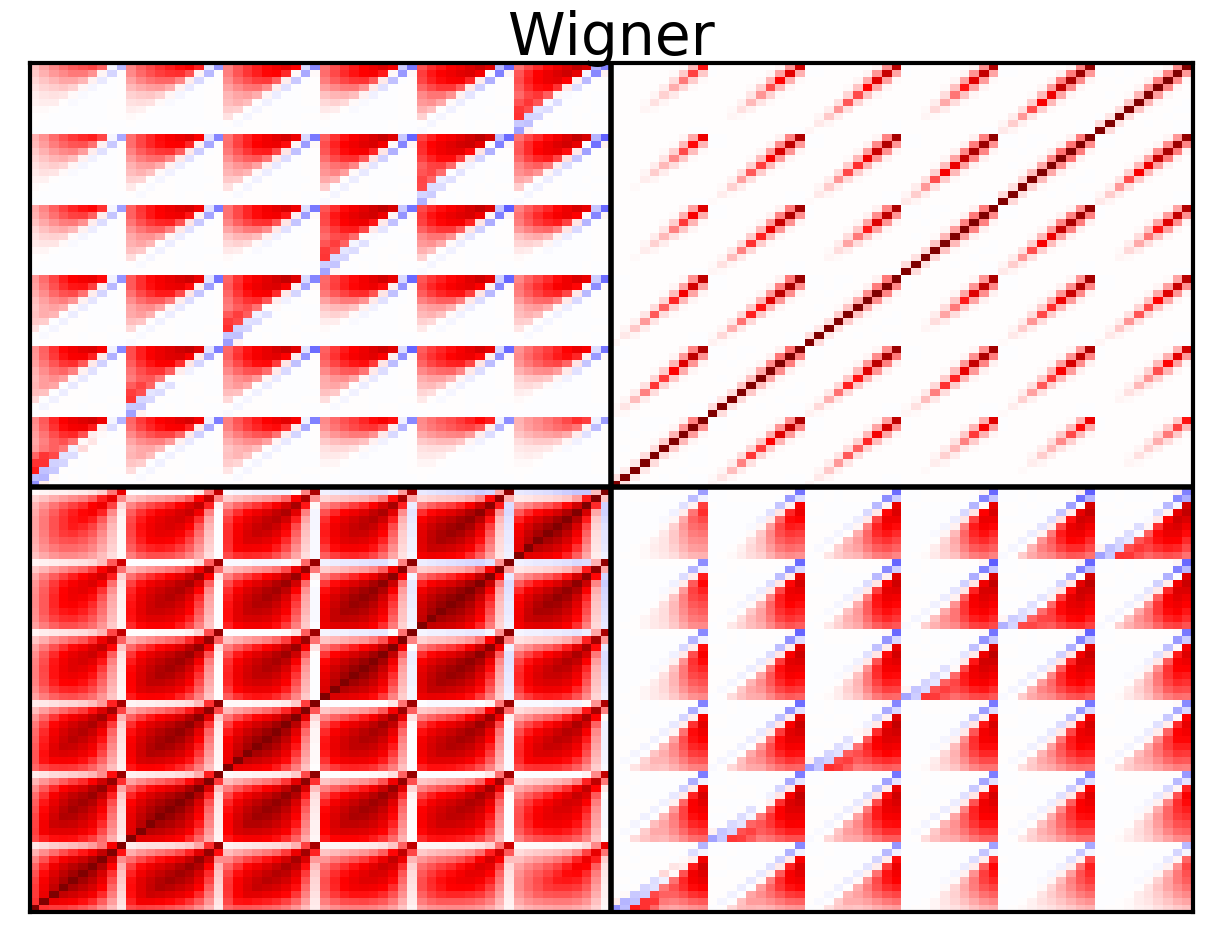

In [85]:
cc=XI_W.cov_utils
corrW=cc.corr_matrix(xiW['cov'])
pcolor(corrW,vmin=-1,vmax=1,cmap='seismic')
# xlabel(r'$\theta$ (degrees)')
# ylabel(r'$\theta$ (degrees)')
hlines(60,0,120)
vlines(60,0,120)
xticks([])
yticks([])
title('Wigner')
show()
# corrL=cc.corr_matrix(clL['cov'])
# pcolor(corrL,vmin=-1,vmax=1,cmap='seismic')

/usr/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


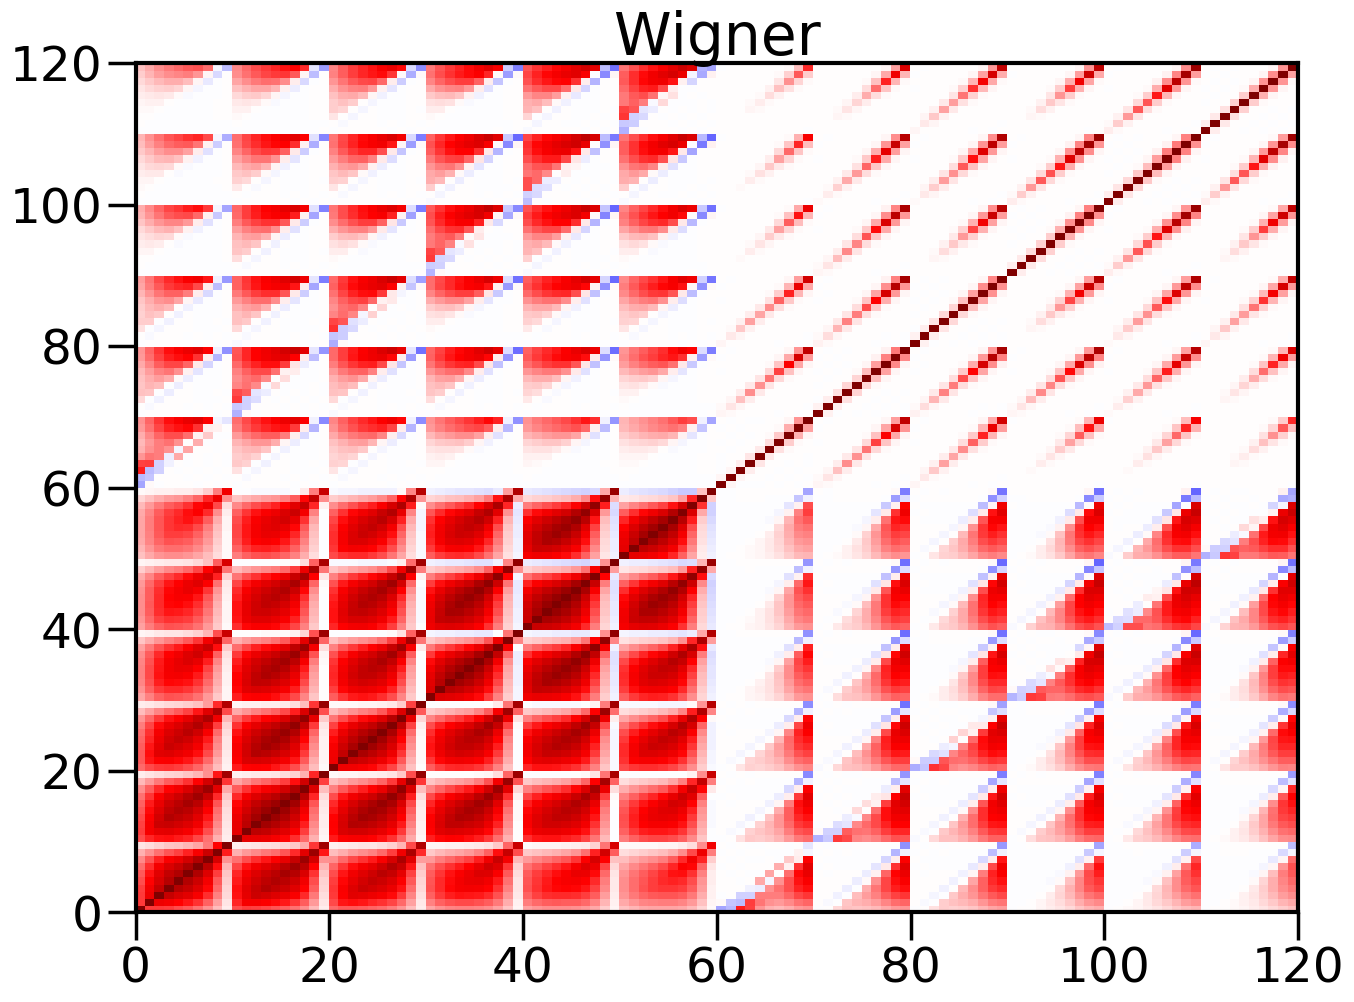

In [86]:
cc=XI_W.cov_utils
corrWL=cc.corr_matrix(xiW_L['cov'])
pcolor(corrWL,vmin=-1,vmax=1,cmap='seismic')
title('Wigner')
show()

In [87]:
corr=('shear','shear')

/usr/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


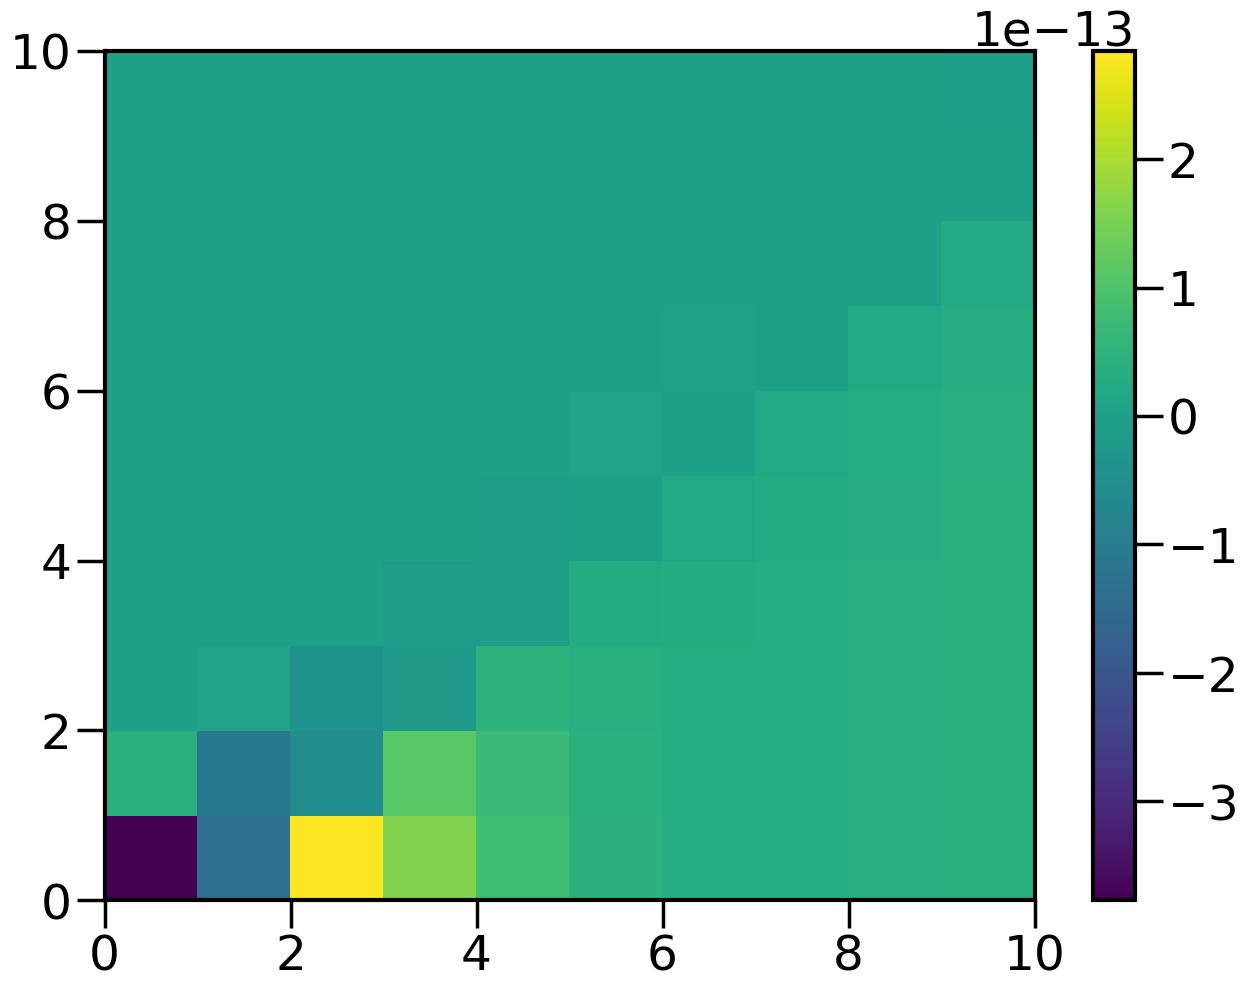

In [88]:
m1m2=(2, 2, 2, -2)
i=0
j=0
cov_t=xiWG['cov'][corr+corr][m1m2][(i,j,i,j)].compute()
pcolor(cov_t['final'])
colorbar()
# print (cov_t)

In [89]:
m1m2=(2,2)

/usr/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


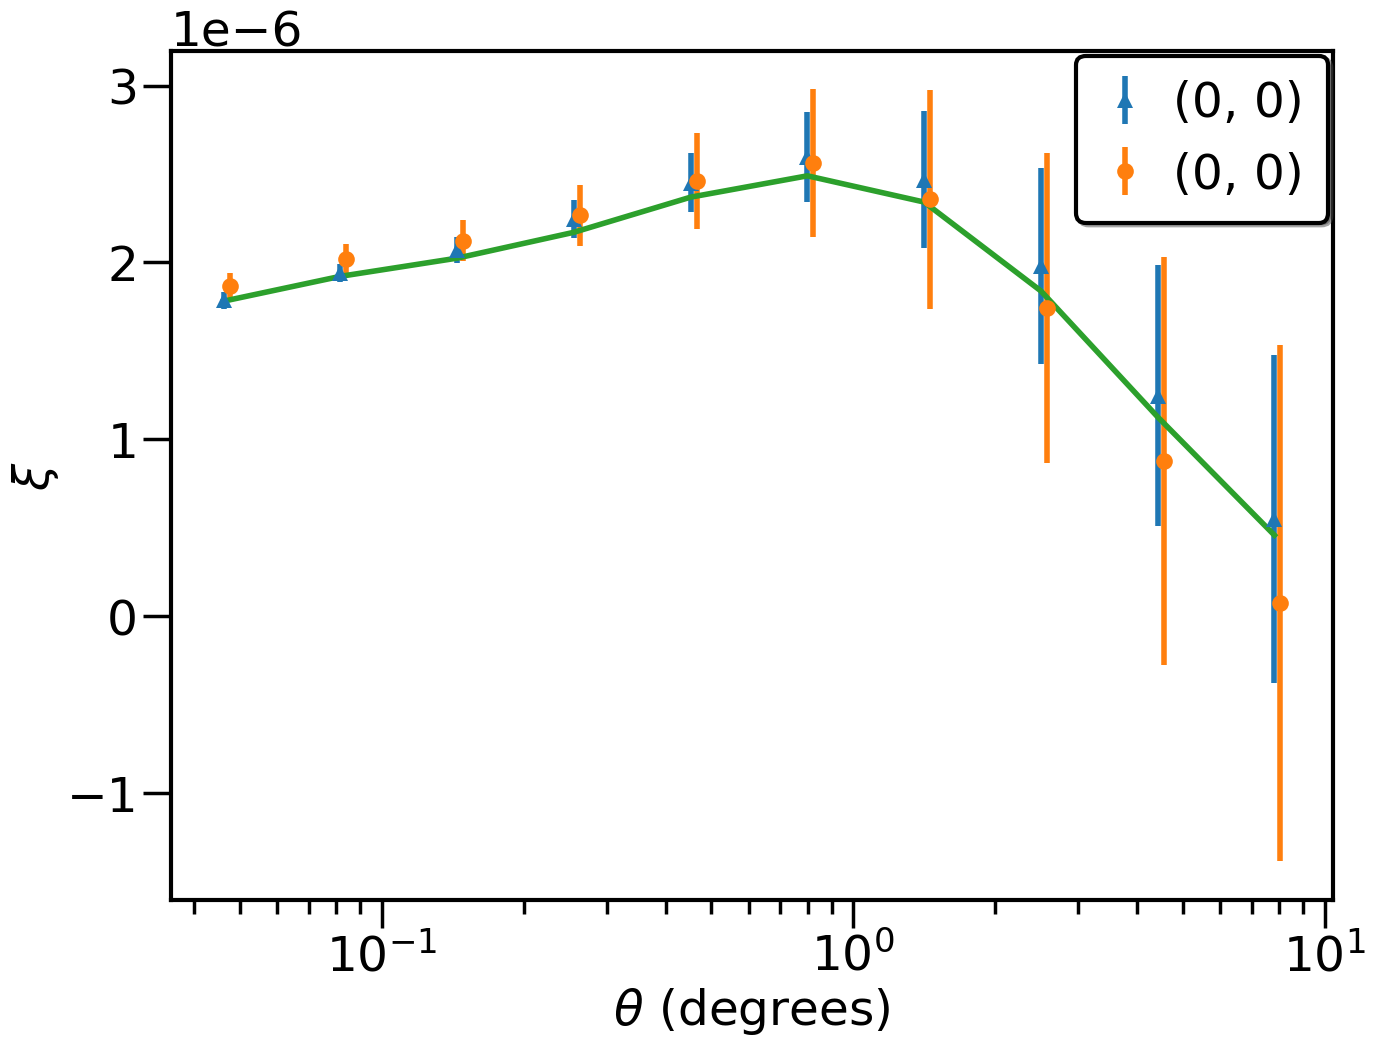

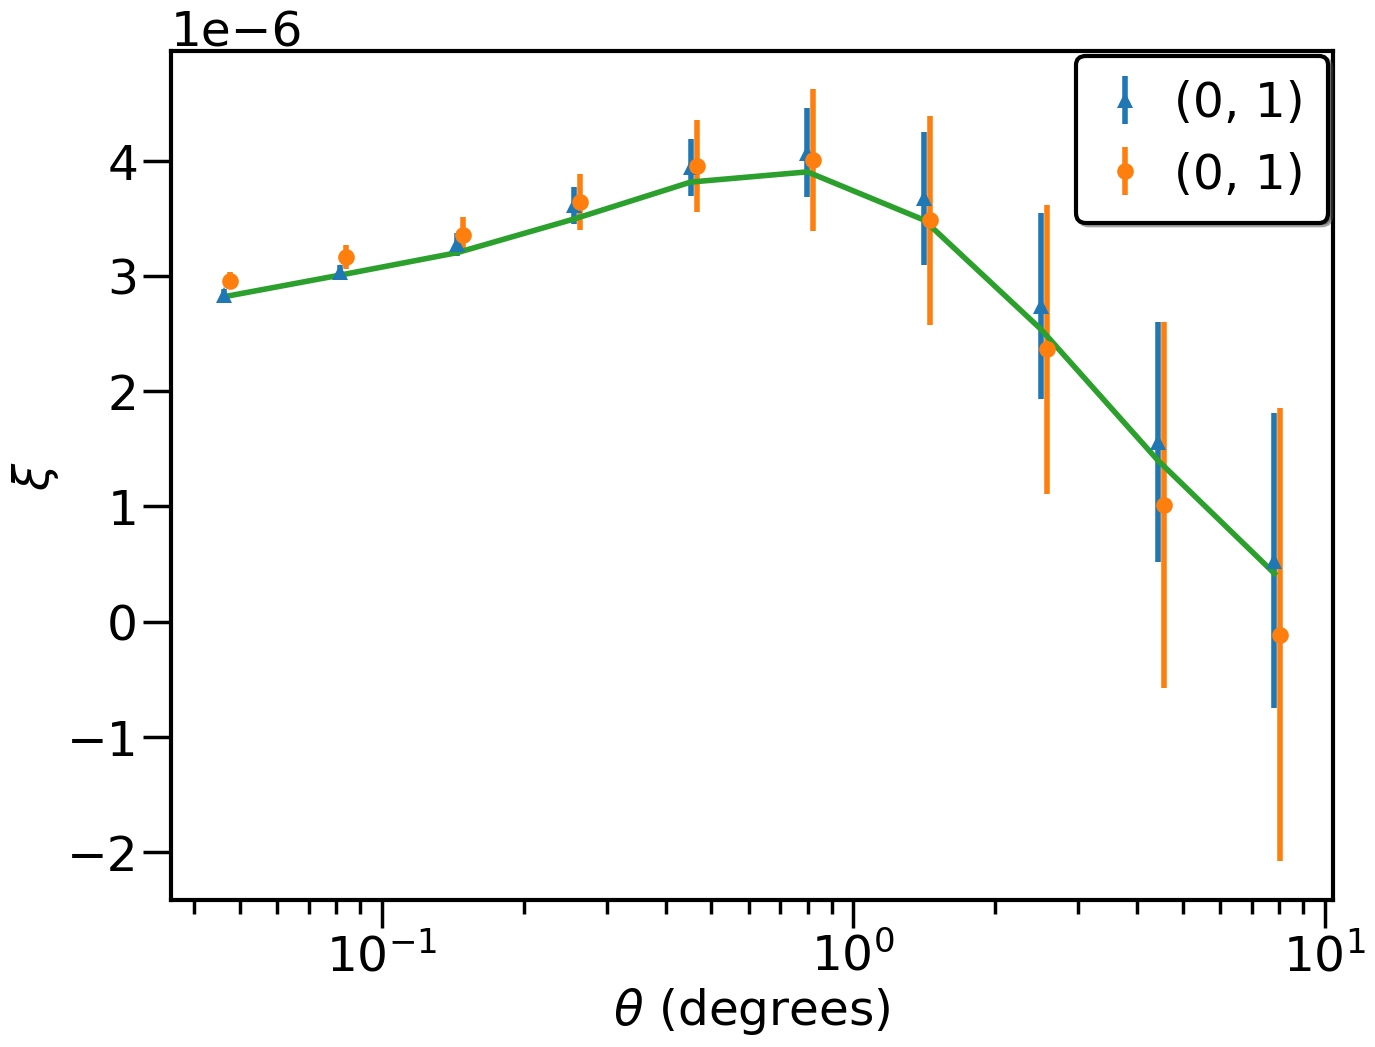

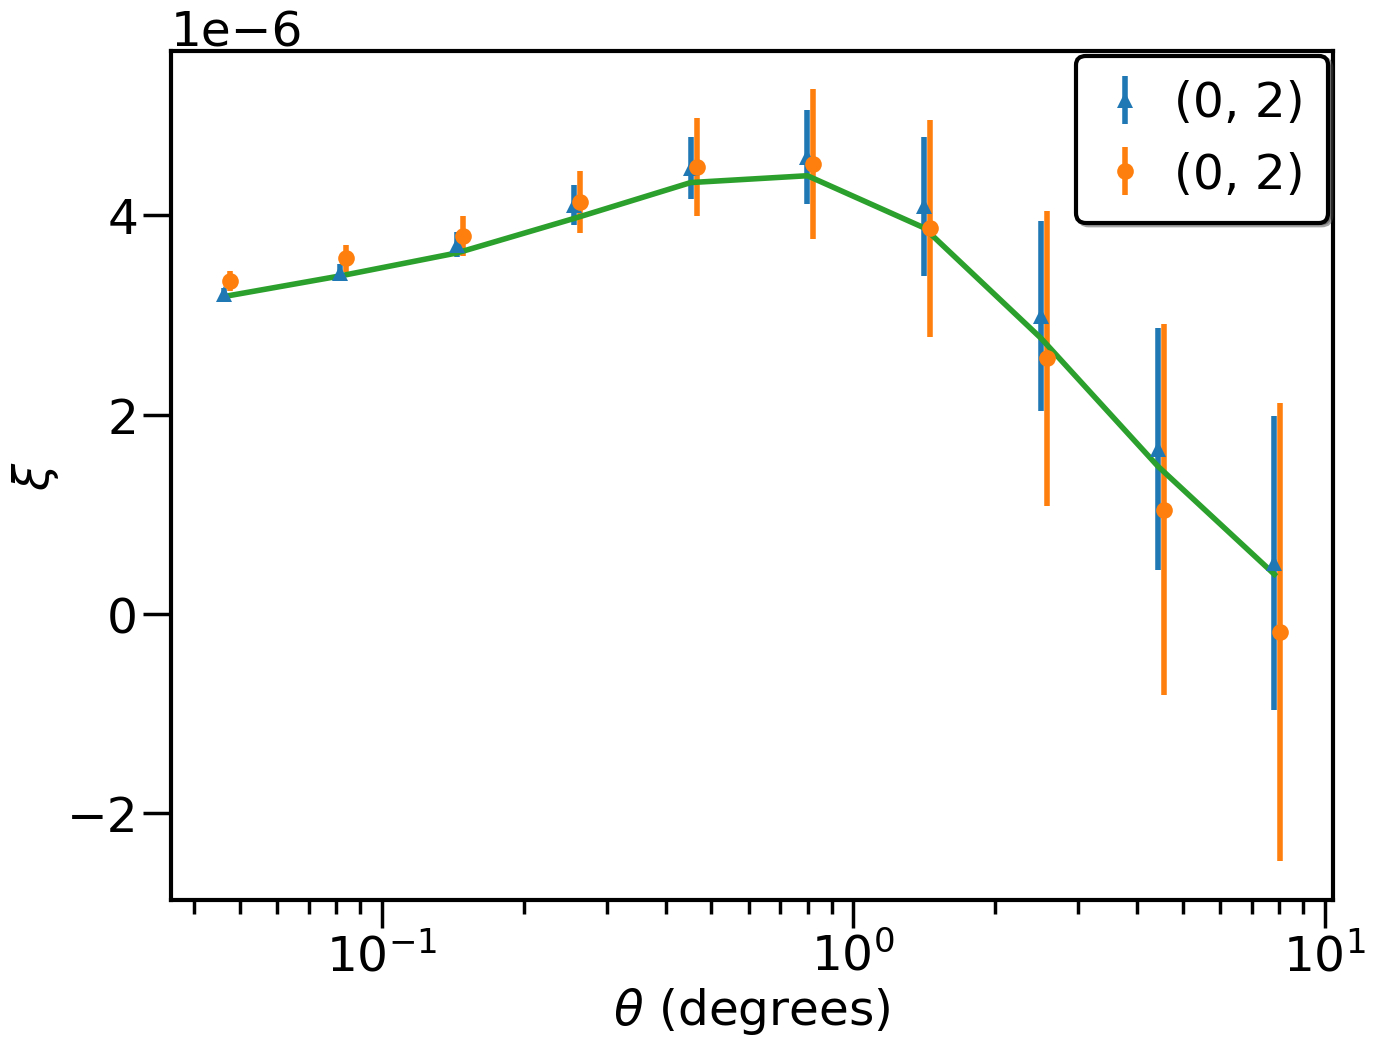

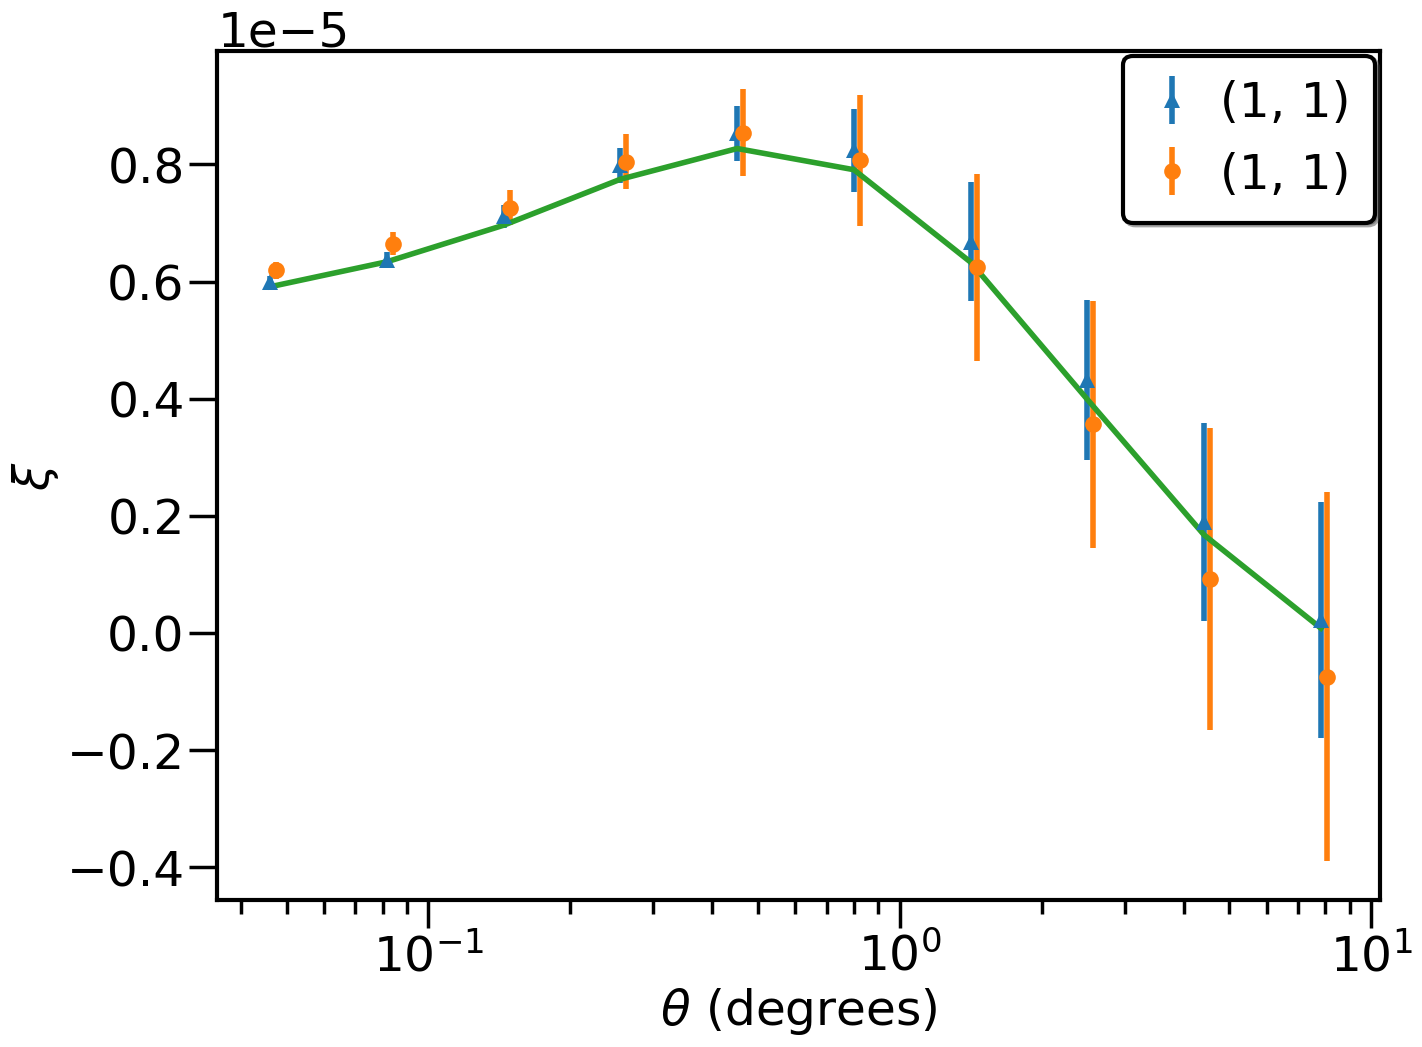

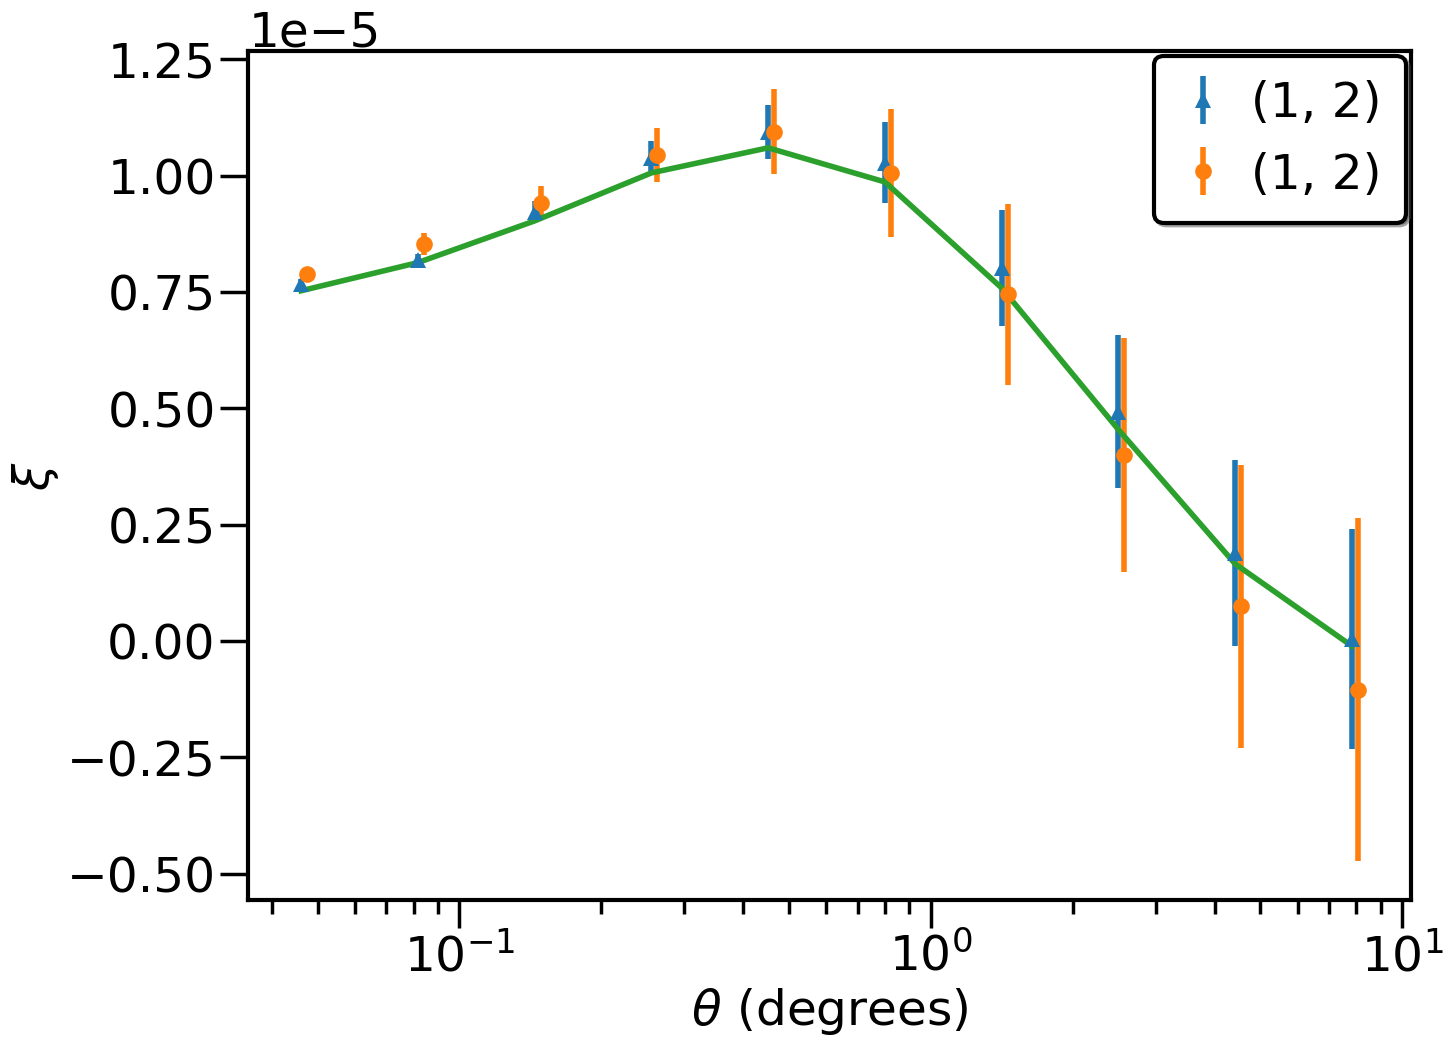

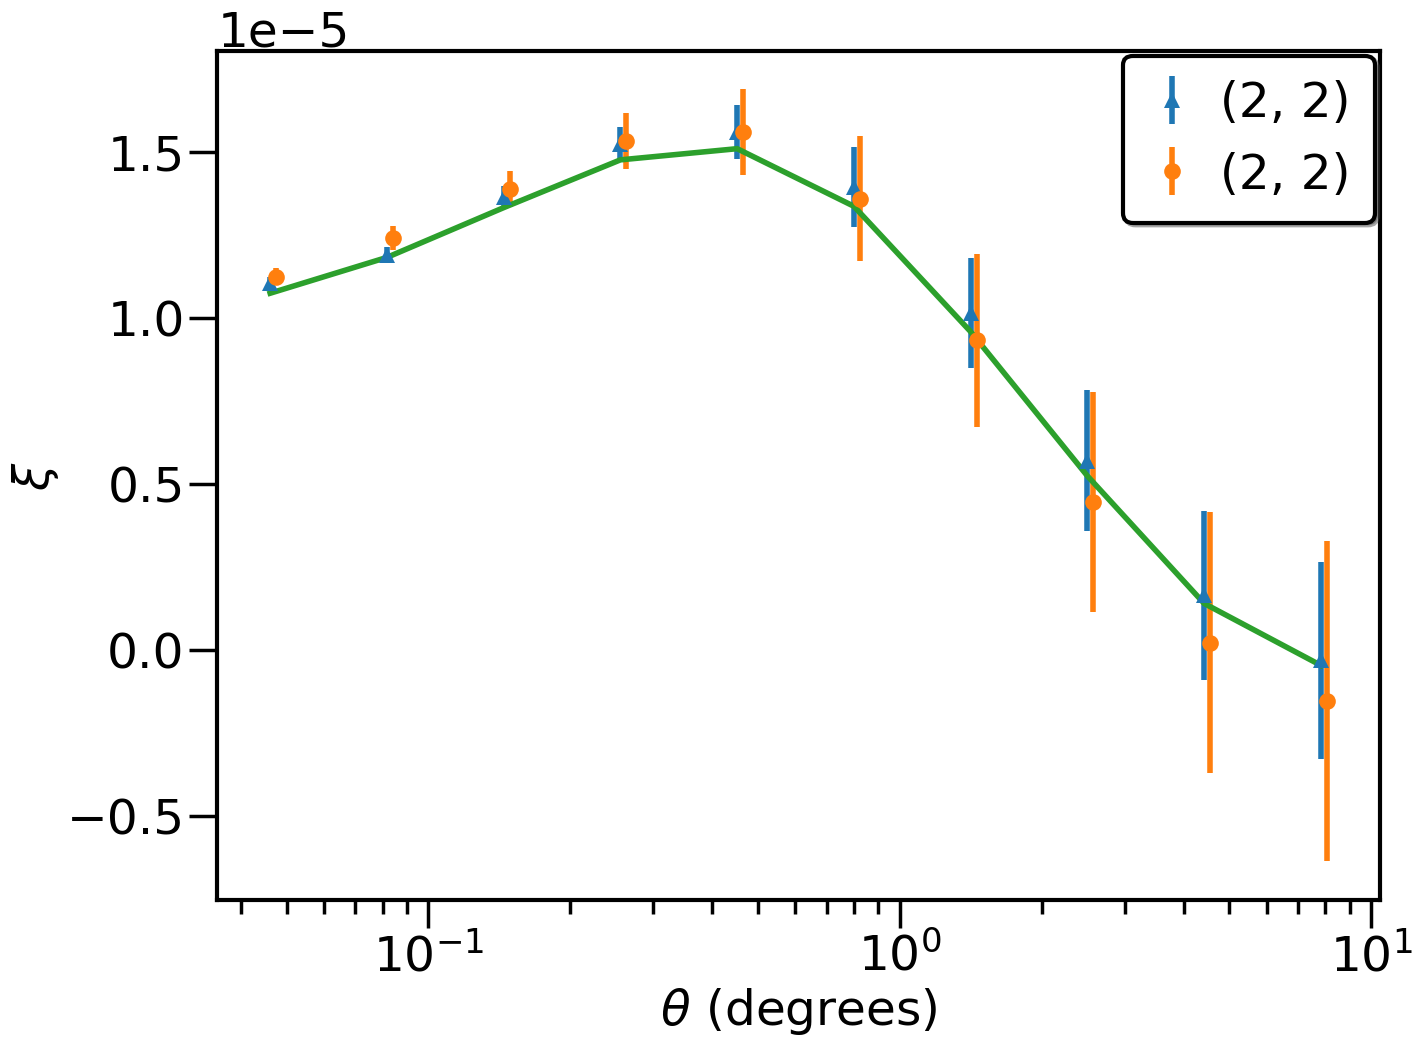

In [90]:
for i in np.arange(nbins):
    for j in np.arange(i,nbins):
        errorbar(thb*1.0,thb*xiHG['xi'][corr][m1m2][(i,j)].compute(),thb*np.sqrt(np.diag(xiHG['cov'][corr+corr][m1m2+m1m2][(i,j,i,j)].compute()['final'])),fmt='^',label=(i,j))
        errorbar(thb*1.03,thb*xiWG_L['xi'][corr][m1m2][(i,j)].compute(),thb*np.sqrt(np.diag(xiWG_L['cov'][corr+corr][m1m2+m1m2][(i,j,i,j)].compute()['final'])),fmt='o',label=(i,j))
        lens1 = ccl.ClTracerLensing(ccl_cosmo, False, z=zs_bins[i]['z'], n=zs_bins[i]['pz'])
        lens2 = ccl.ClTracerLensing(ccl_cosmo, False, z=zs_bins[j]['z'], n=zs_bins[j]['pz'])
        cls = ccl.angular_cl(ccl_cosmo, lens1, lens2, XI_W_L.l)
        xi_plus = ccl.correlation(ccl_cosmo, XI_W_L.l, cls, XI_W_L.HT.theta[m1m2]/d2r,corr_type='L+', method='FFTLog')
        xi_b=XI_W_L.binning.bin_1d(xi=xi_plus,bin_utils=XI_W_L.xi_bin_utils[m1m2])
        plot(thb,thb*xi_b)
        xscale('log')
#         yscale('log')
        xlabel(r'$\theta$ (degrees)')
        ylabel(r'$\xi$')
        legend()
        show()

11:33:31 WARNING:No handles with labels found to put in legend.
11:33:31 WARNING:No handles with labels found to put in legend.
11:33:31 WARNING:No handles with labels found to put in legend.
11:33:32 WARNING:No handles with labels found to put in legend.
11:33:32 WARNING:No handles with labels found to put in legend.
11:33:33 WARNING:No handles with labels found to put in legend.
/usr/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


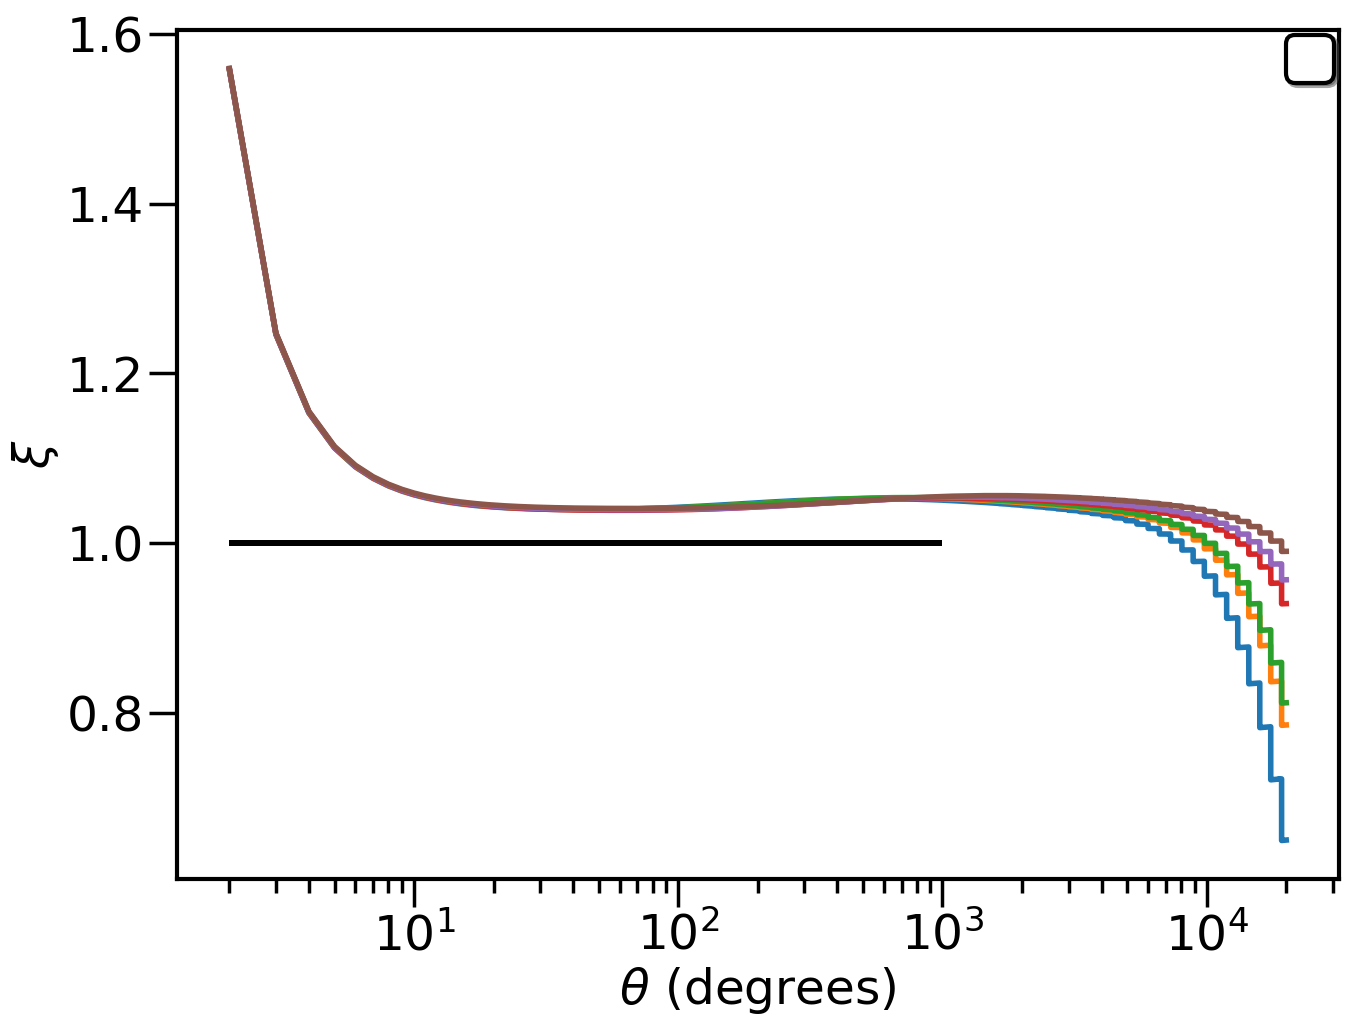

In [91]:
for i in np.arange(nbins):
    for j in np.arange(i,nbins):
#         errorbar(thb,xiHG['xi'][corr][m1m2][(i,j)].compute(),np.sqrt(np.diag(xiHG['cov'][corr+corr][m1m2+m1m2][(i,j,i,j)].compute()['final'])),fmt='o',label=(i,j))
#         plot(XI_W_L.l,xiWG_L['cl'][corr][(i,j)].compute(),marker='o',label=(i,j))
#         plot(XI_W_L.l,clWG_L['cl'][corr][(i,j)].compute(),marker='o',label=(i,j))
        lens1 = ccl.ClTracerLensing(ccl_cosmo, False, z=zs_bins[i]['z'], n=zs_bins[i]['pz'])
        lens2 = ccl.ClTracerLensing(ccl_cosmo, False, z=zs_bins[j]['z'], n=zs_bins[j]['pz'])
        cls = ccl.angular_cl(ccl_cosmo, lens1, lens2, XI_W_L.l)
#         xi_plus = ccl.correlation(ccl_cosmo, ell, cls, th,corr_type='L+', method='FFTLog')
#         plot(XI_W_L.l,cls)
        plot(XI_W_L.l,clWG_L['cl'][corr][(i,j)].compute()/cls)
        xscale('log')
#         yscale('log')
        hlines(1,2,1000)
        xlabel(r'$\theta$ (degrees)')
        ylabel(r'$\xi$')
        legend()
#         show()

/usr/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


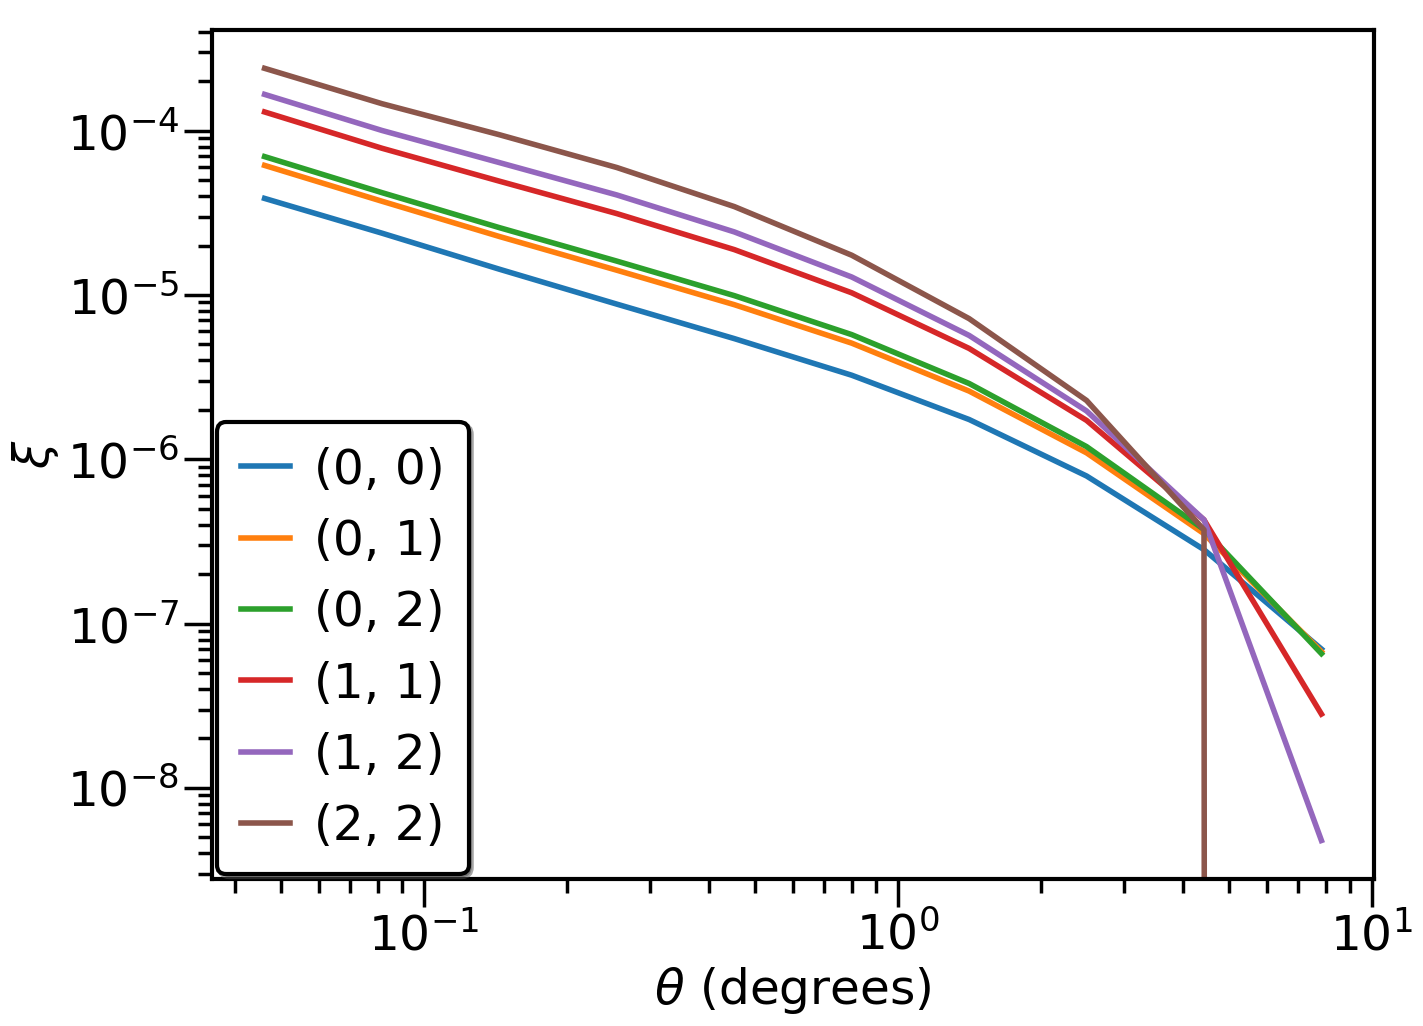

In [92]:
for i in np.arange(nbins):
    for j in np.arange(i,nbins):
        plot(thb,xiHG['xi'][corr][m1m2][(i,j)].compute(),label=(i,j))
xscale('log')
yscale('log')
xlabel(r'$\theta$ (degrees)')
ylabel(r'$\xi$')
legend()

/usr/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


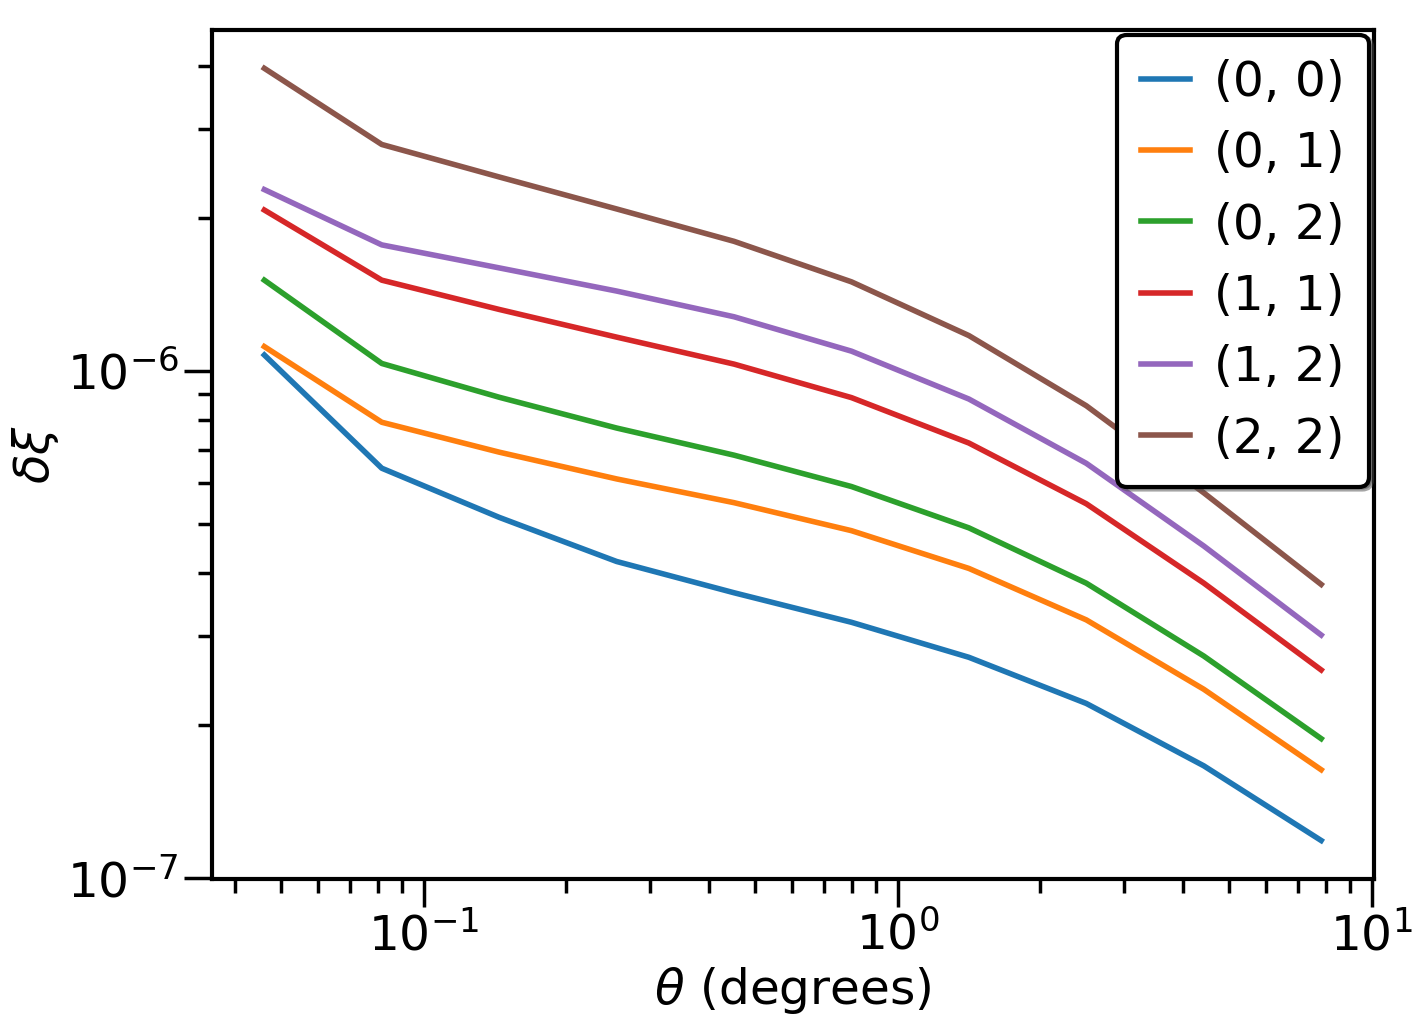

In [93]:
for i in np.arange(nbins):
    for j in np.arange(i,nbins):
        plot(thb, np.sqrt(np.diag(xiHG['cov'][corr+corr][m1m2+m1m2][(i,j,i,j)].compute()['final'])),label=(i,j))
xscale('log')
yscale('log')
xlabel(r'$\theta$ (degrees)')
ylabel(r'$\delta \xi $')
legend()

/usr/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


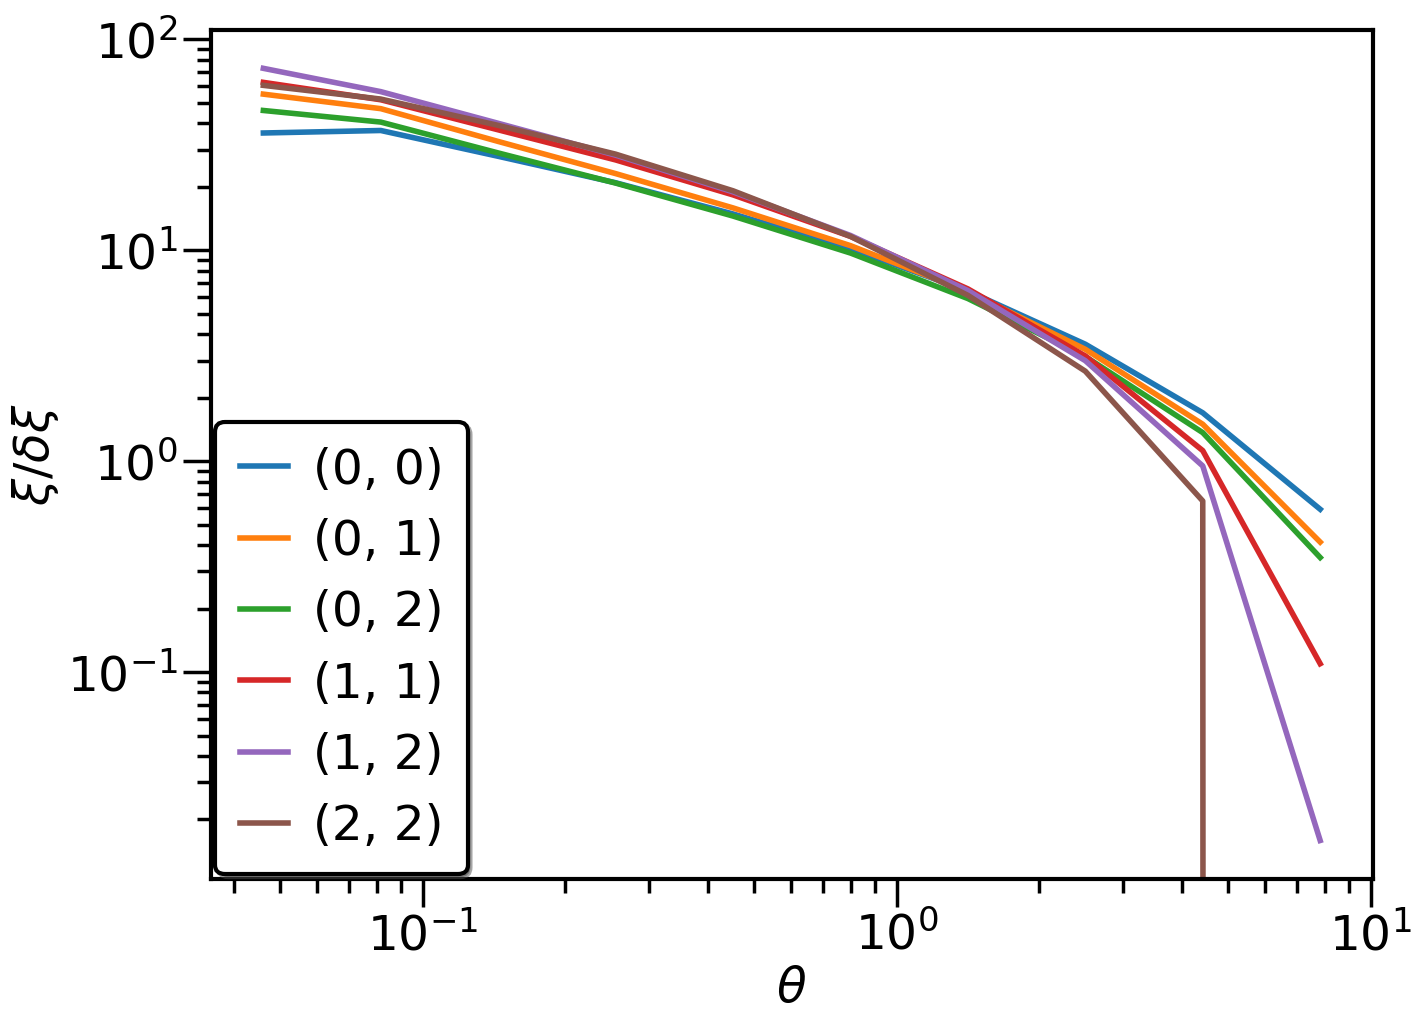

In [94]:
for i in np.arange(nbins):
    for j in np.arange(i,nbins):
        plot(thb,xiHG['xi'][corr][m1m2][(i,j)].compute()/np.sqrt(np.diag(xiHG['cov'][corr+corr][m1m2+m1m2][(i,j,i,j)].compute()['final'])),label=(i,j))
xscale('log')
yscale('log')
xlabel(r'$\theta$')
ylabel(r'$\xi/\delta \xi$')
legend()

In [95]:
nbins=3

/usr/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


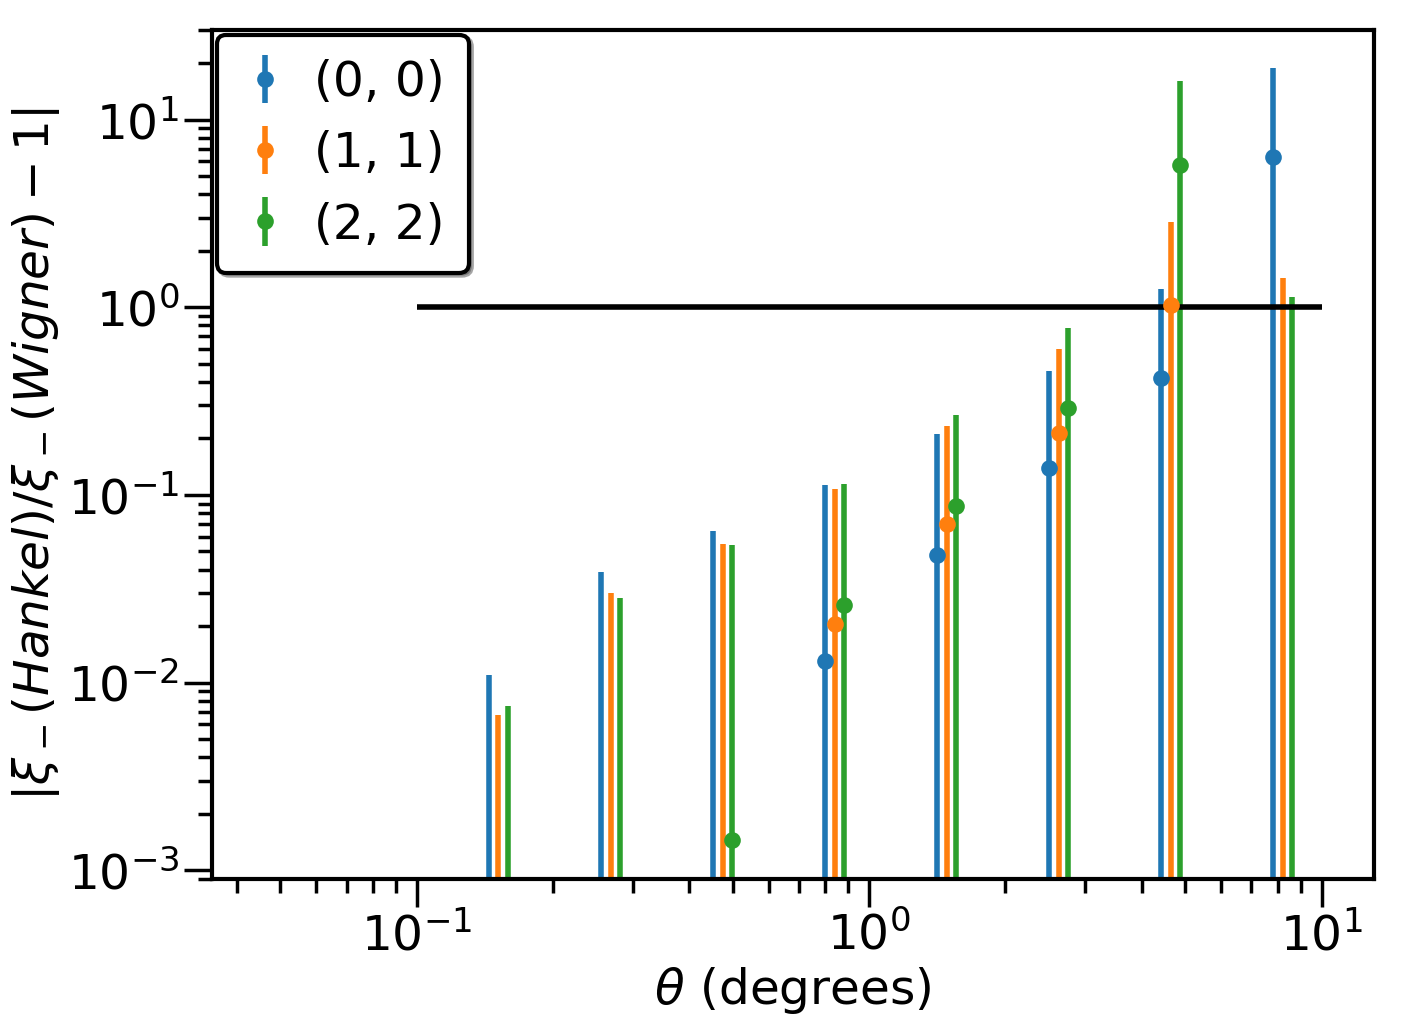

In [96]:
corr=('shear','shear')
m1m2=(2,2)
for i in np.arange(nbins):
    j=i
    errorbar(thb*(1+i*0.05),(xiHG['xi'][corr][m1m2][(i,j)].compute()/xiWG['xi'][corr][m1m2][(i,j)].compute()-1),
                         np.sqrt(np.diag(xiHG['cov'][corr+corr][m1m2+m1m2][(i,j,i,j)].compute()['final']))/xiWG['xi'][corr][m1m2][(i,j)].compute(),
             fmt='o',label=(i,j)) 
xscale('log')
# yscale('log')
xlabel(r'$\theta$ (degrees)')
ylabel(r'$|\xi_- ( {Hankel})/\xi_- ( {Wigner})-1|$')
hlines(1,0.1,10)
yscale('log')
legend()

/usr/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


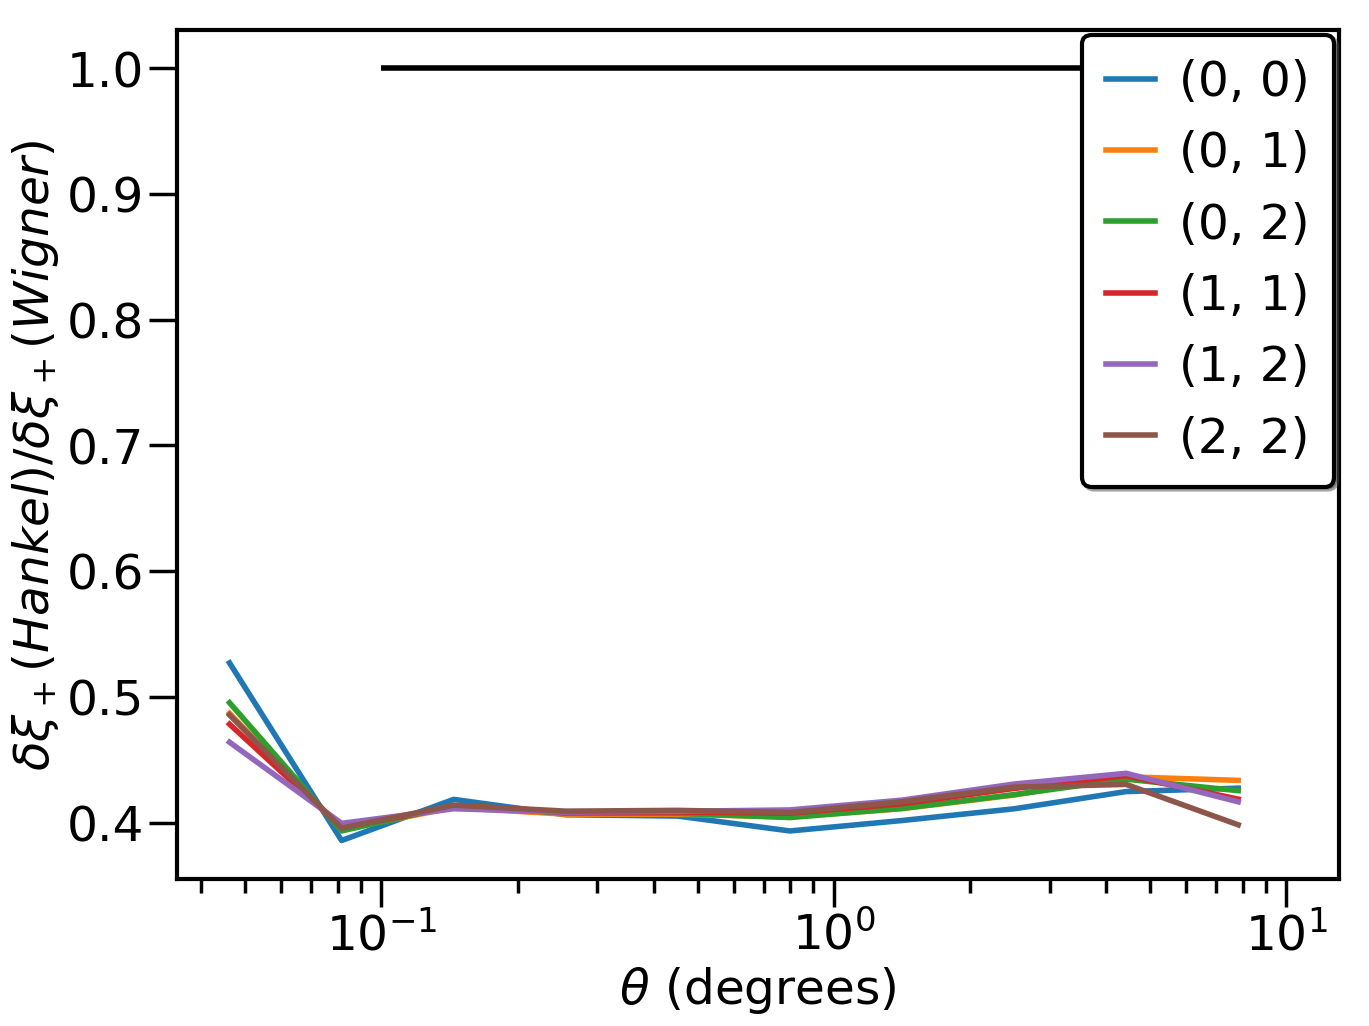

In [97]:
for i in np.arange(nbins):
    for j in np.arange(i,nbins):
        plot(thb,(np.diag(xiHG['cov'][corr+corr][m1m2+m1m2][(i,j,i,j)].compute()['final']))/(np.diag(xiWG['cov'][corr+corr][m1m2+m1m2][(i,j,i,j)].compute()['final'])),label=(i,j))
xscale('log')
# yscale('log')
xlabel(r'$\theta$ (degrees)')
ylabel(r'$\delta\xi_+(Hankel)/\delta\xi_+(Wigner)$')
hlines(1,0.1,10)
legend()

/usr/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


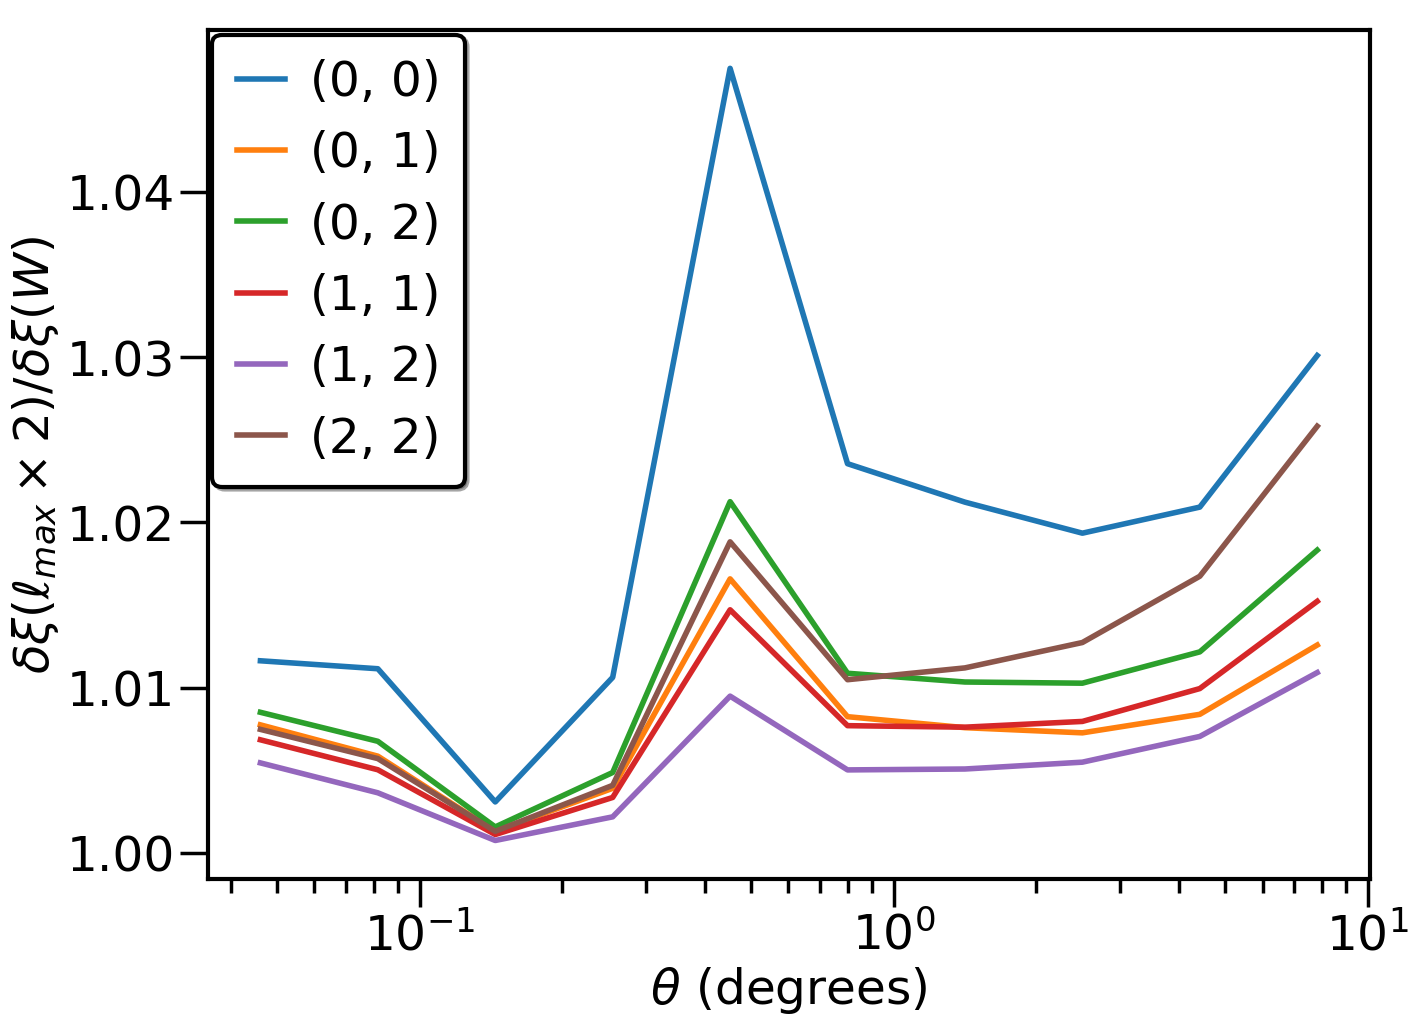

In [98]:
for i in np.arange(nbins):
    for j in np.arange(i,nbins):
        plot(thb,np.sqrt(np.diag(xiWG_L['cov'][corr+corr][m1m2+m1m2][(i,j,i,j)].compute()['final']))/np.sqrt(np.diag(xiWG['cov'][corr+corr][m1m2+m1m2][(i,j,i,j)].compute()['final'])),label=(i,j))
xscale('log')
# yscale('log')
xlabel(r'$\theta$ (degrees)')
ylabel(r'$\delta\xi(\ell_{max}\times2)/\delta\xi(W)$')
# hlines(1,0.1,10)
legend()

In [99]:
m1m2

(2, 2)

/usr/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


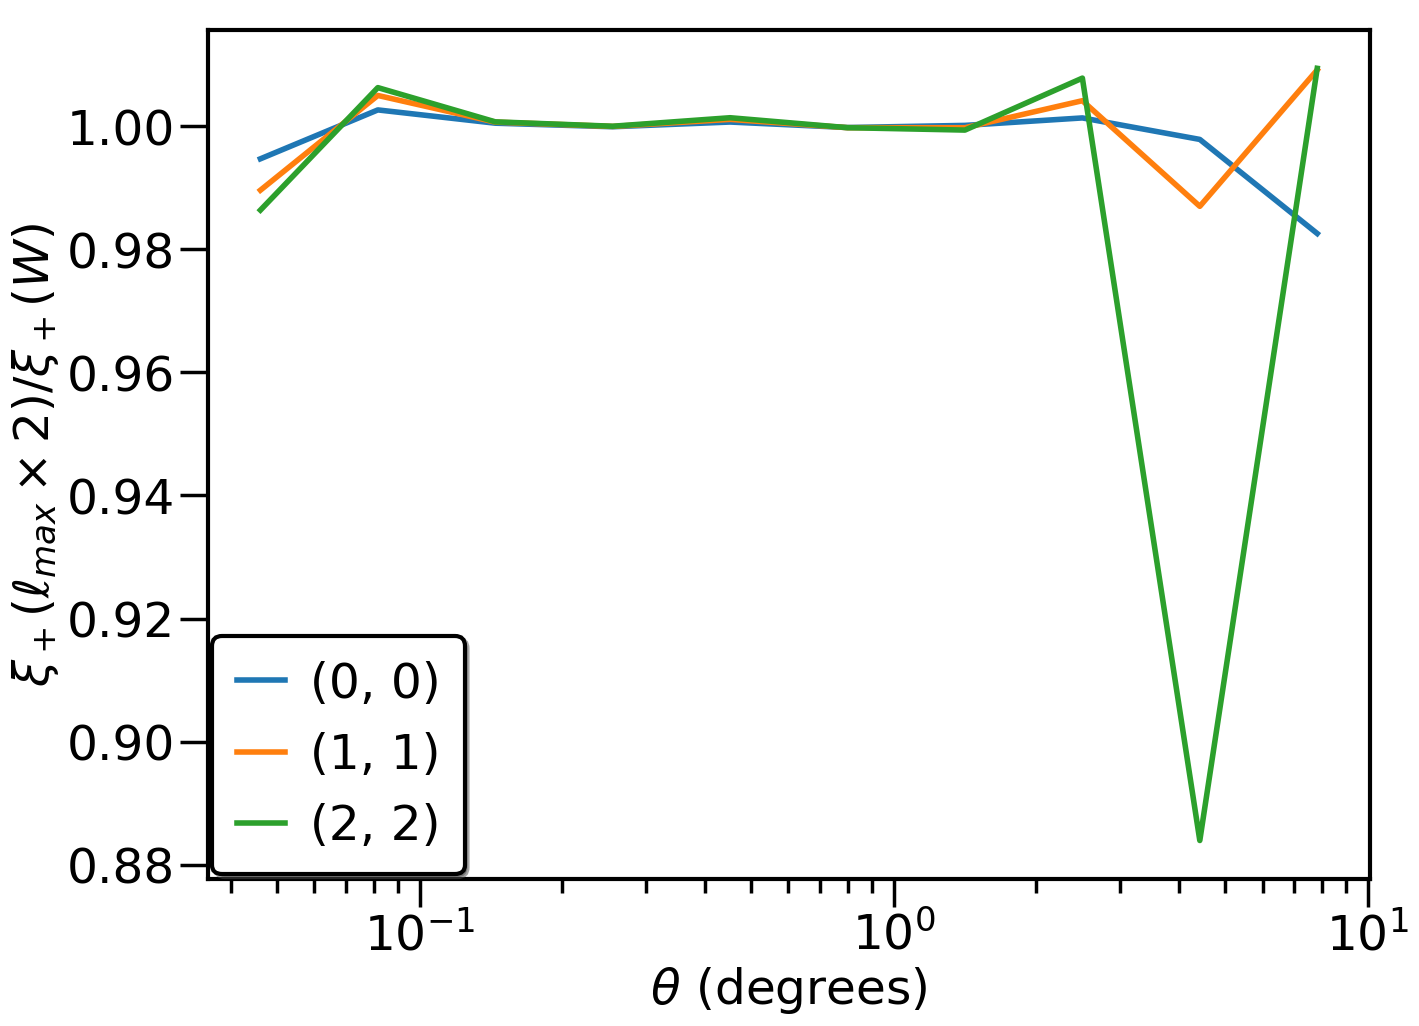

In [100]:
for i in np.arange(nbins):
    j=i
    plot(thb,xiWG_L['xi'][corr][m1m2][(i,j)].compute()/xiWG['xi'][corr][m1m2][(i,j)].compute(),label=(i,j))
xscale('log')
# yscale('log')
xlabel(r'$\theta$ (degrees)')
ylabel(r'$\xi_+ (\ell_{max}\times2)/\xi_+ (W)$')
# hlines(1,0.1,10)
legend()

In [101]:
crash

NameError: name 'crash' is not defined

# Galaxy X Lensing Correlation function covariance

In [183]:
import galaxy_utils
reload(galaxy_utils)
from galaxy_utils import *

In [184]:
import cov_utils
reload(cov_utils)
from cov_utils import *

In [206]:
import cov_3X2
reload(cov_3X2)
from cov_3X2 import *
from wigner_transform import *

In [207]:
#Setup redshift bins
zmin=0.3
zmax=2

z=np.linspace(0,5,200)
pzs=lsst_pz_source(z=z)
x=z<zmax
x*=z>zmin
z=z[x]
pzs=pzs[x]

ns0=26 #26+np.inf #ns=inf means shape noise is zero
nbins=5  # Number of tomographic bins
z_sigma=0.01
zs_bins=source_tomo_bins(zp=z,p_zp=pzs,ns=ns0,nz_bins=nbins,
                         ztrue_func=ztrue_given_pz_Gaussian,zp_bias=np.zeros_like(z),
                        zp_sigma=z_sigma*np.ones_like(z))

ng0=10 #26+np.inf #ns=inf means shape noise is zero
# nbins=3  # Number of tomographic bins
z_sigma=0.1
zg_bins=source_tomo_bins(zp=z,p_zp=pzs,ns=ns0,nz_bins=nbins,
                         ztrue_func=ztrue_given_pz_Gaussian,zp_bias=np.zeros_like(z),
                        zp_sigma=z_sigma*np.ones_like(z))


# nbins=np.int(nbins*(nbins+1.)/2.)
# zl_bins=lens_wt_tomo_bins(zp=z,p_zp=pzs,ns=ns0,nz_bins=nbins,z_bins=np.linspace(zmin,1.5,nbins),
#                           ztrue_func=ztrue_given_pz_Gaussian,zp_bias=np.zeros_like(z),
#                         zp_sigma=z_sigma*np.ones_like(z))

SSV_cov=False
tidal_SSV=False

/usr/lib/python3.7/site-packages/astropy/units/quantity.py:639: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/usr/lib/python3.7/site-packages/astropy/units/quantity.py:639: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/usr/lib/python3.7/site-packages/astropy/units/quantity.py:639: RuntimeWarning: invalid value encountered in less_equal
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


In [208]:
do_xi=True
bin_xi=True
bin_cl=True
th_min=1./60
th_max=10
n_th_bins=20
n_th=160
th=np.logspace(np.log10(th_min*2),np.log10(th_max),n_th)
th_bins=np.logspace(np.log10(th_min*2),np.log10(th_max),n_th_bins+1)
thb=np.sqrt(th_bins[1:]*th_bins[:-1])

In [209]:
corr_ggl=('galaxy','shear')
corr_gg=('galaxy','galaxy')
corr_ll=('shear','shear')
m1m2=(0,2)
m1m2_gg=(0,0)

In [210]:
lmin_cl_Bins=lmin_cl+10
lmax_cl_Bins=lmax_cl-10
Nl_bins=40
l_bins=np.int64(np.logspace(np.log10(lmin_cl_Bins),np.log10(lmax_cl_Bins),Nl_bins))

In [211]:
# Wigner Transform setup
l_W=np.arange(2,l_max,dtype='int')
WT_kwargs={'l':l_W ,'theta':th*d2r ,'m1_m2':[(0,0),(0,2),(2,2),(2,-2)]}
# %time WTggl=wigner_transform(**WT_kwargs)

XI_W= cov_3X2(zs_bins=zs_bins,l=l0,do_cov=do_cov,bin_cl=bin_cl,l_bins=l_bins,zg_bins=zg_bins,
               SSV_cov=SSV_cov,tidal_SSV_cov=tidal_SSV,do_xi=do_xi,HT=WTggl,
#               HT_kwargs=HT_kwargs,
               bin_xi=bin_xi,theta_bins=th_bins)#ns=np.inf)

In [212]:
XI_W.cov_utils.Om_W

3.7699111843077517

In [213]:
%time cl_Wggl=XI_W.cl_tomo(corrs=[corr_ll,corr_ggl,corr_gg])

/usr/lib/python3.7/site-packages/astropy/units/quantity.py:639: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


CPU times: user 15.7 s, sys: 510 ms, total: 16.2 s
Wall time: 10.8 s


In [214]:
%time xiWggl=XI_W.xi_tomo(corrs=[corr_ll,corr_ggl,corr_gg])
%time xiW_ggl=xiWggl['stack'].compute()

/usr/lib/python3.7/site-packages/astropy/units/quantity.py:639: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


CPU times: user 5.46 s, sys: 311 ms, total: 5.77 s
Wall time: 5.39 s
True True
True True
True True
True True
TrueTrue True
 True
TrueTrue True
 TrueTrue
 True
TrueTrue True
 True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
TrueTrue True
 True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
TrueTrue  True
True
True True
True True
True True
True True
True True
True True
True True
True TrueTrue
 True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True TrueTrue
True True
 True
True True True
True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
TrueTrue True
 True
TrueTrue True
 True
True True
True True
True True
True True
True True
True True
True True
True True
TrueTrue True
 True
True True
T

In [215]:
cl_Wggl['cov'][corr_ggl+corr_ggl][(0,0,0,1)]['G1423'].compute().min()

1.830285908798819e-15

/usr/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


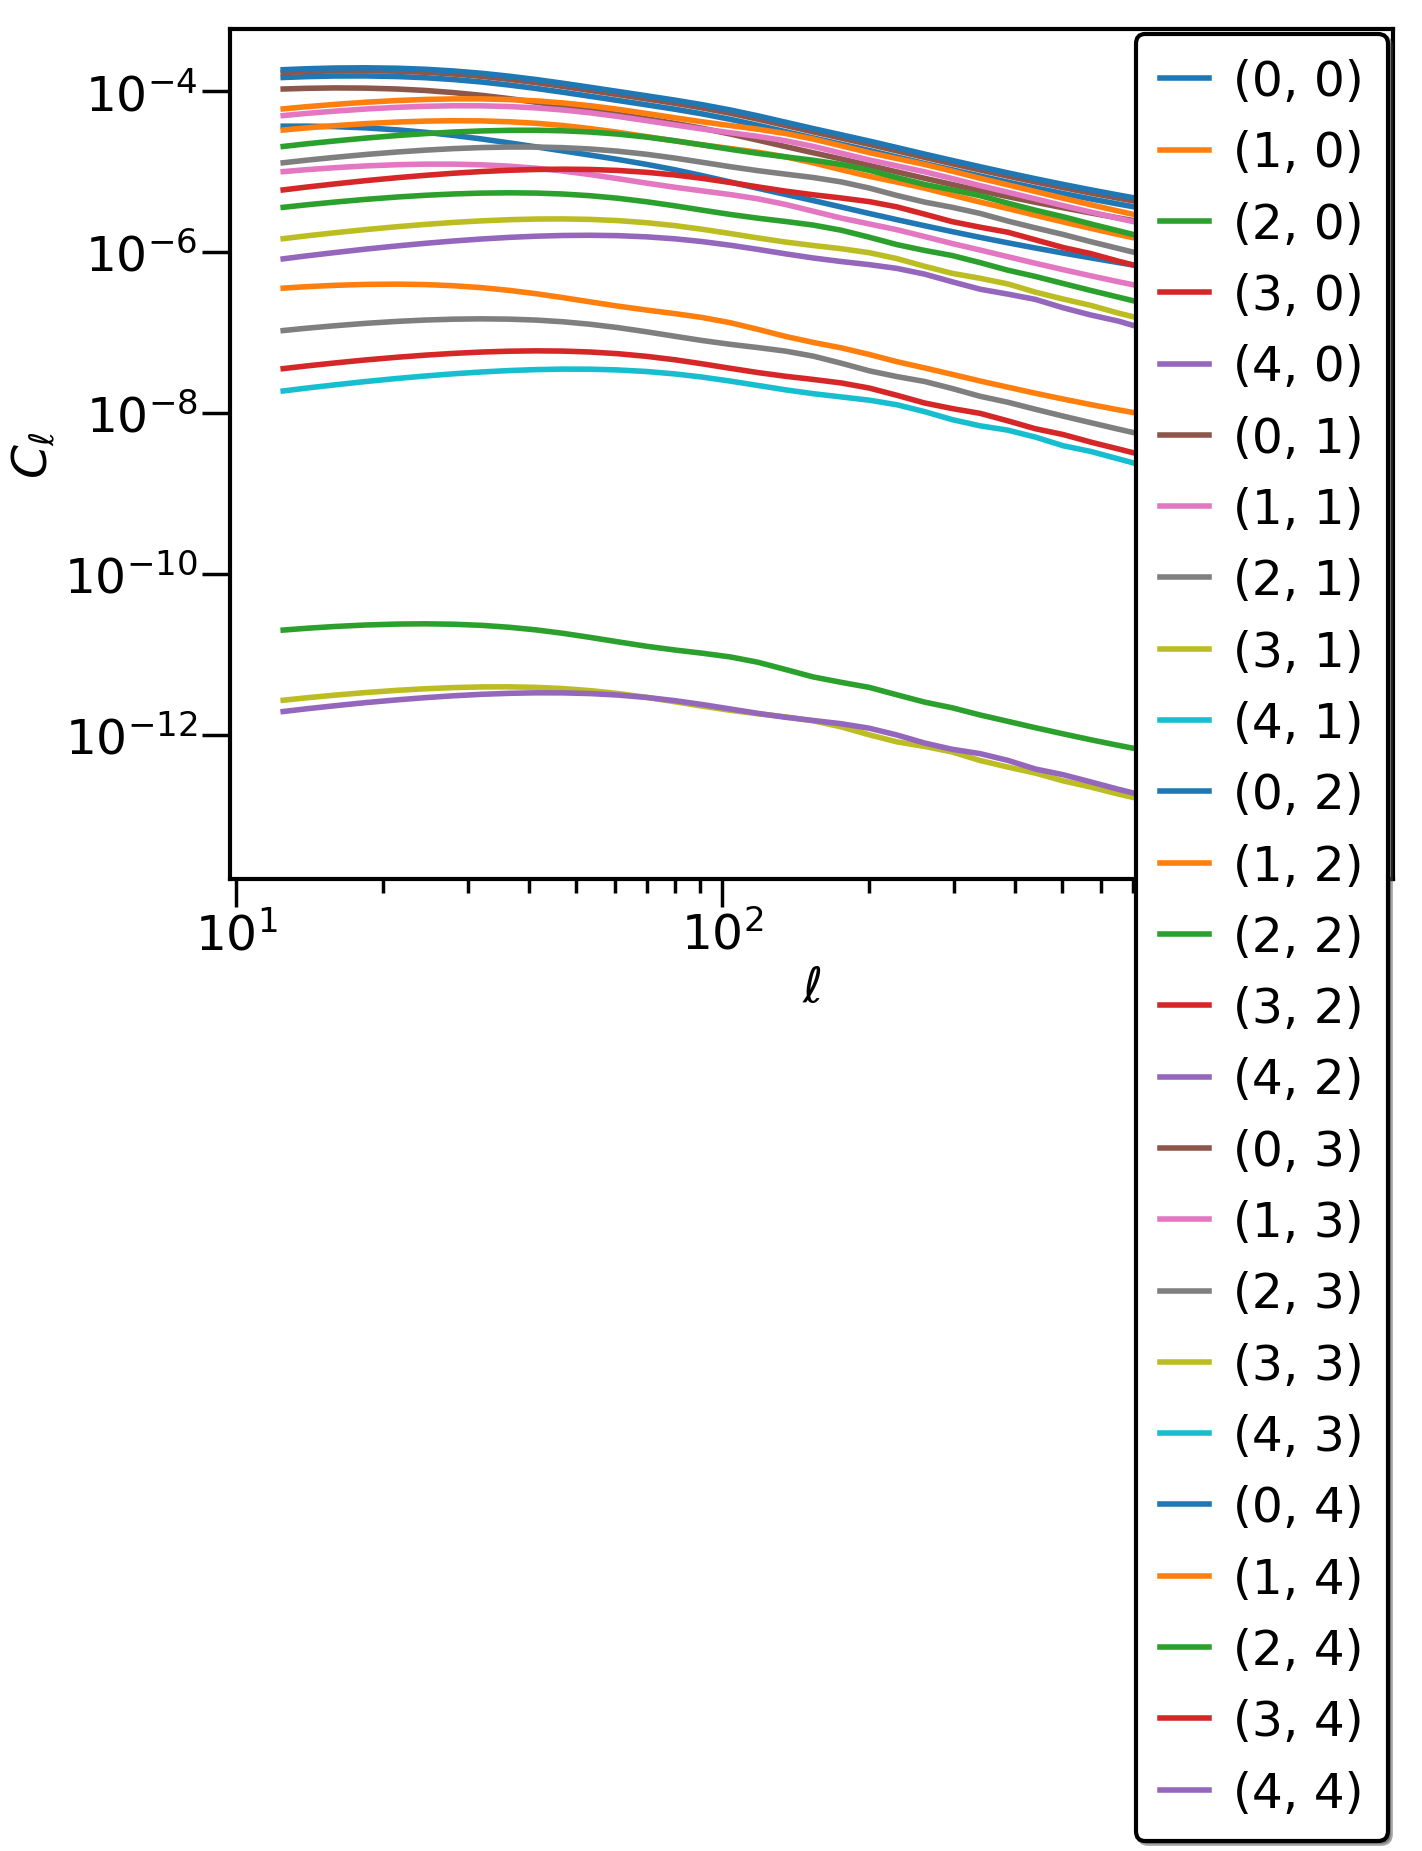

In [216]:
clb_T=cl_Wggl['cl_b'][corr_ggl].compute()
for (i,j) in clb_T[corr_ggl].keys():
#     for j in np.arange(i,nbins):
        plot(lb,clb_T[corr_ggl][(i,j)],label=(i,j))
        xscale('log')
        yscale('log')
        xlabel(r'$\ell$')
        ylabel(r'$C_\ell$')
        legend()
#         show()

In [217]:
covv

{'final': None,
 'G': None,
 'G1324': array([8.73666992e-09, 1.17889145e-08, 1.40614521e-08, ...,
        1.76885312e-10, 1.76885032e-10, 1.76884751e-10]),
 'G1423': array([2.44306309e-10, 4.30832761e-10, 6.15028989e-10, ...,
        4.12172433e-16, 4.12037755e-16, 4.11903139e-16]),
 'SSC': None,
 'kernel': array([[8.57099303e-32, 1.22336972e-31, 2.02220417e-31, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [8.57270714e-32, 1.22361439e-31, 2.02260859e-31, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [8.57442142e-32, 1.22385907e-31, 2.02301305e-31, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        ...,
        [3.42634069e-31, 4.89054354e-31, 8.08396461e-31, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [3.42668340e-31, 4.89103271e-31, 8.08477319e-31, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [3.42702613e-31, 4.89152190e-31, 8.08558181e-31, ...,
         0.000000

/usr/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


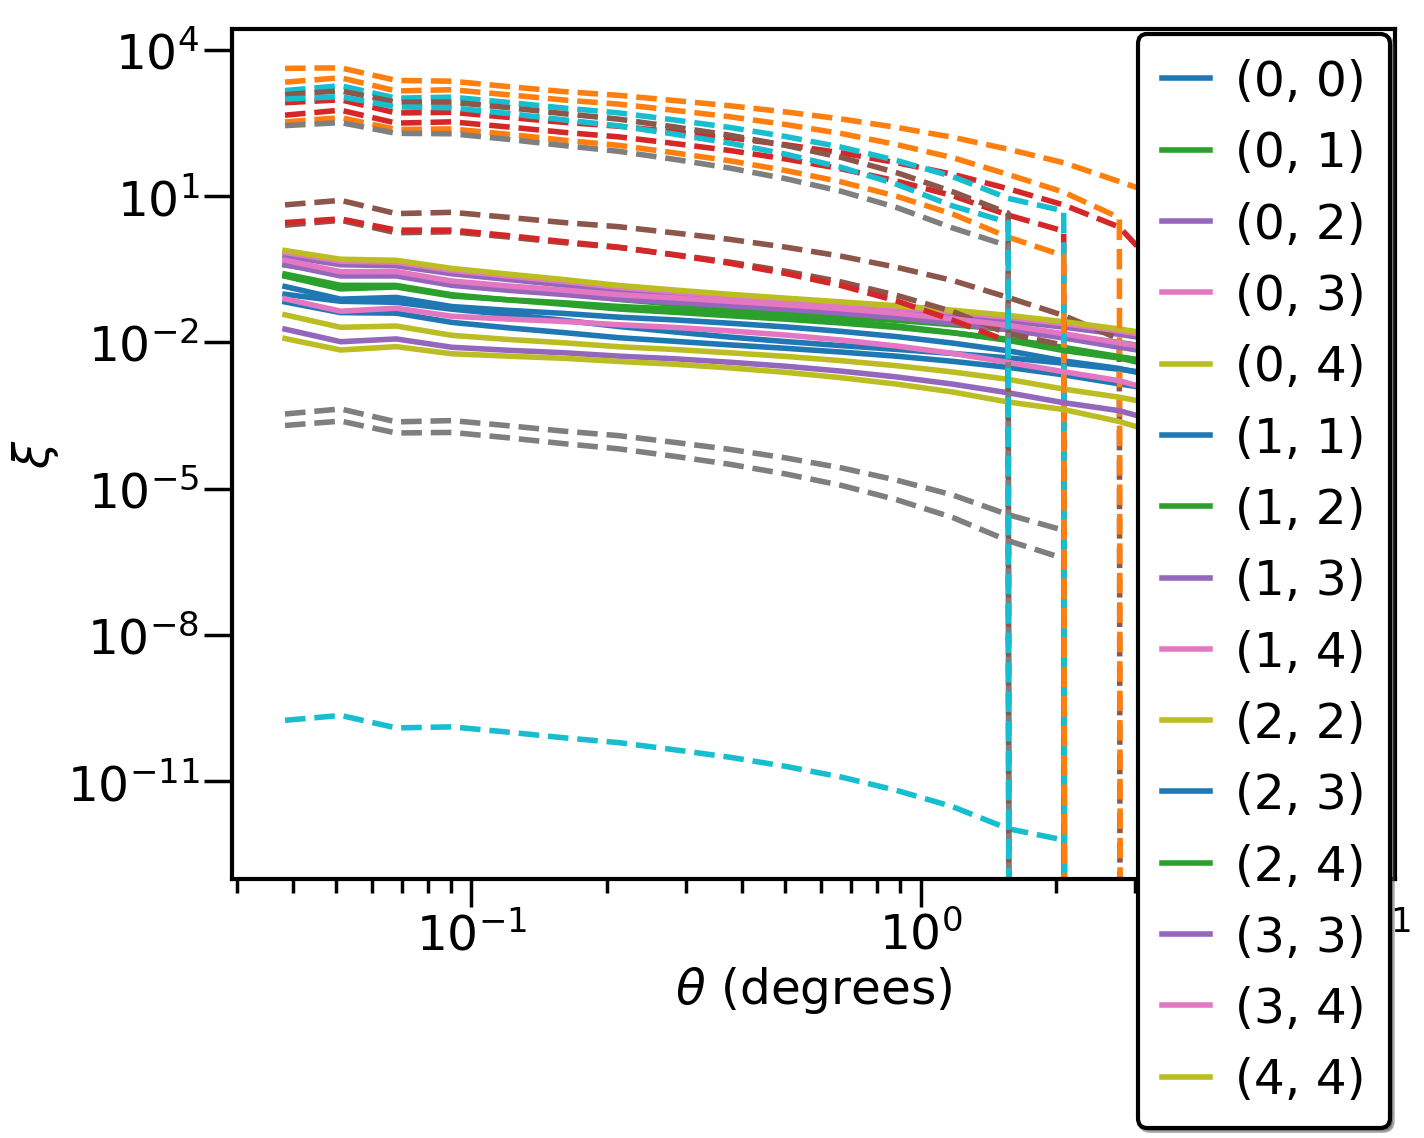

In [218]:
for i in np.arange(nbins):
    for j in np.arange(i,nbins):
        plot(thb,xiWggl['xi'][corr_ggl][m1m2][(i,j)].compute(),label=(i,j))
        plot(thb,xiWggl['xi'][corr_gg][m1m2_gg][(i,j)].compute(),ls='--')
        xscale('log')
        yscale('log')
        xlabel(r'$\theta$ (degrees)')
        ylabel(r'$\xi$')
        legend()
show()

In [219]:
np.all(np.isfinite(np.sqrt(XI_W.HT.norm)))

True

True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True


/usr/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


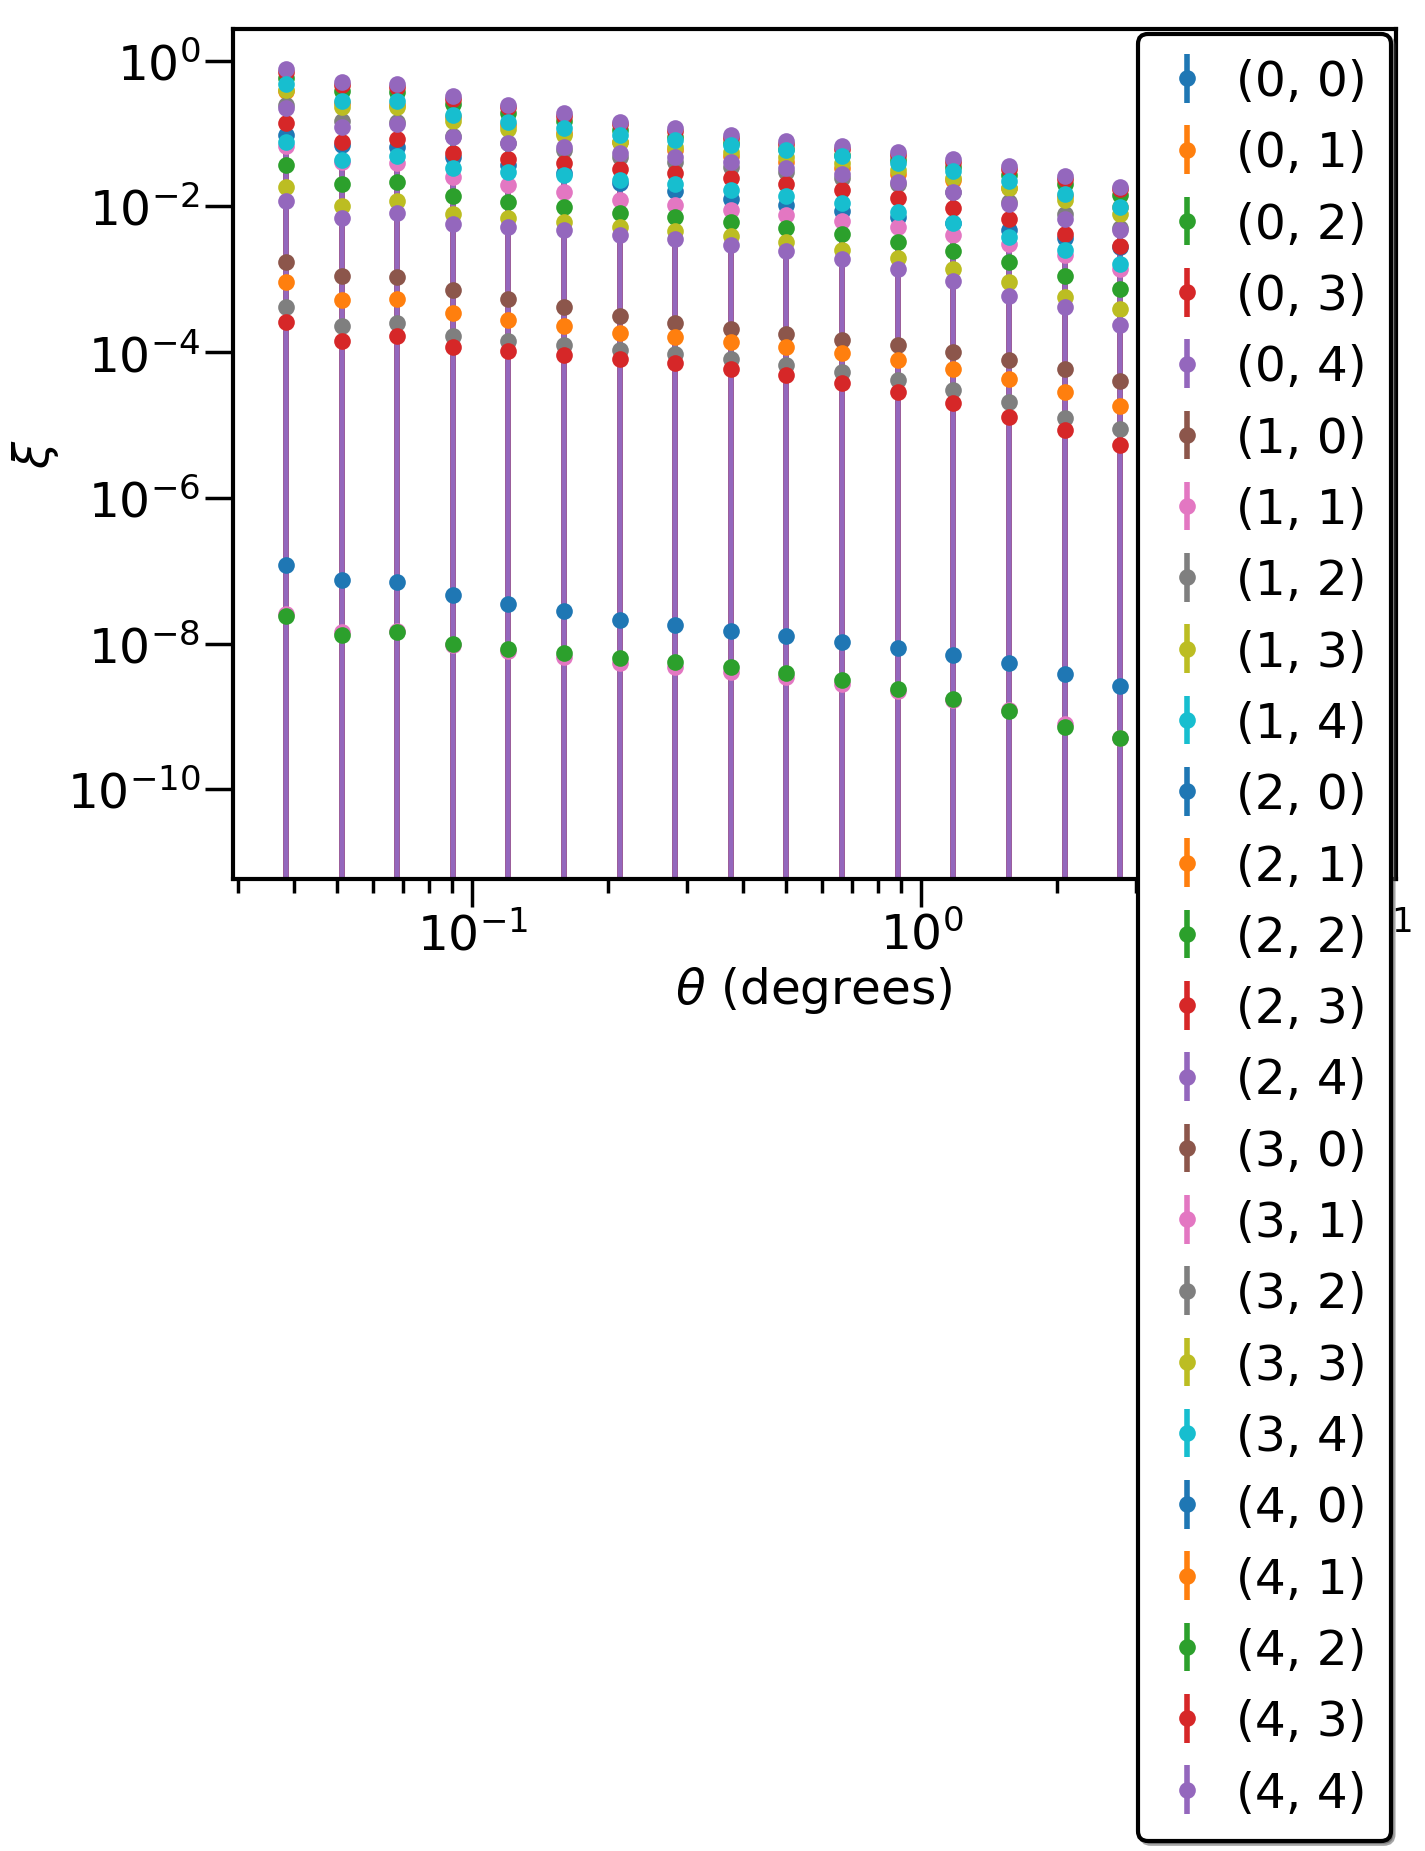

In [220]:
for i in np.arange(nbins):
    for j in np.arange(0,nbins):
        errorbar(thb,xiWggl['xi'][corr_ggl][m1m2][(i,j)].compute(),np.sqrt(np.diag(xiWggl['cov'][corr_ggl+corr_ggl][m1m2+m1m2][(i,j,i,j)].compute()['final'])),fmt='o',label=(i,j))
xscale('log')
yscale('log')
xlabel(r'$\theta$ (degrees)')
ylabel(r'$\xi$')
legend()

True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True


/usr/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


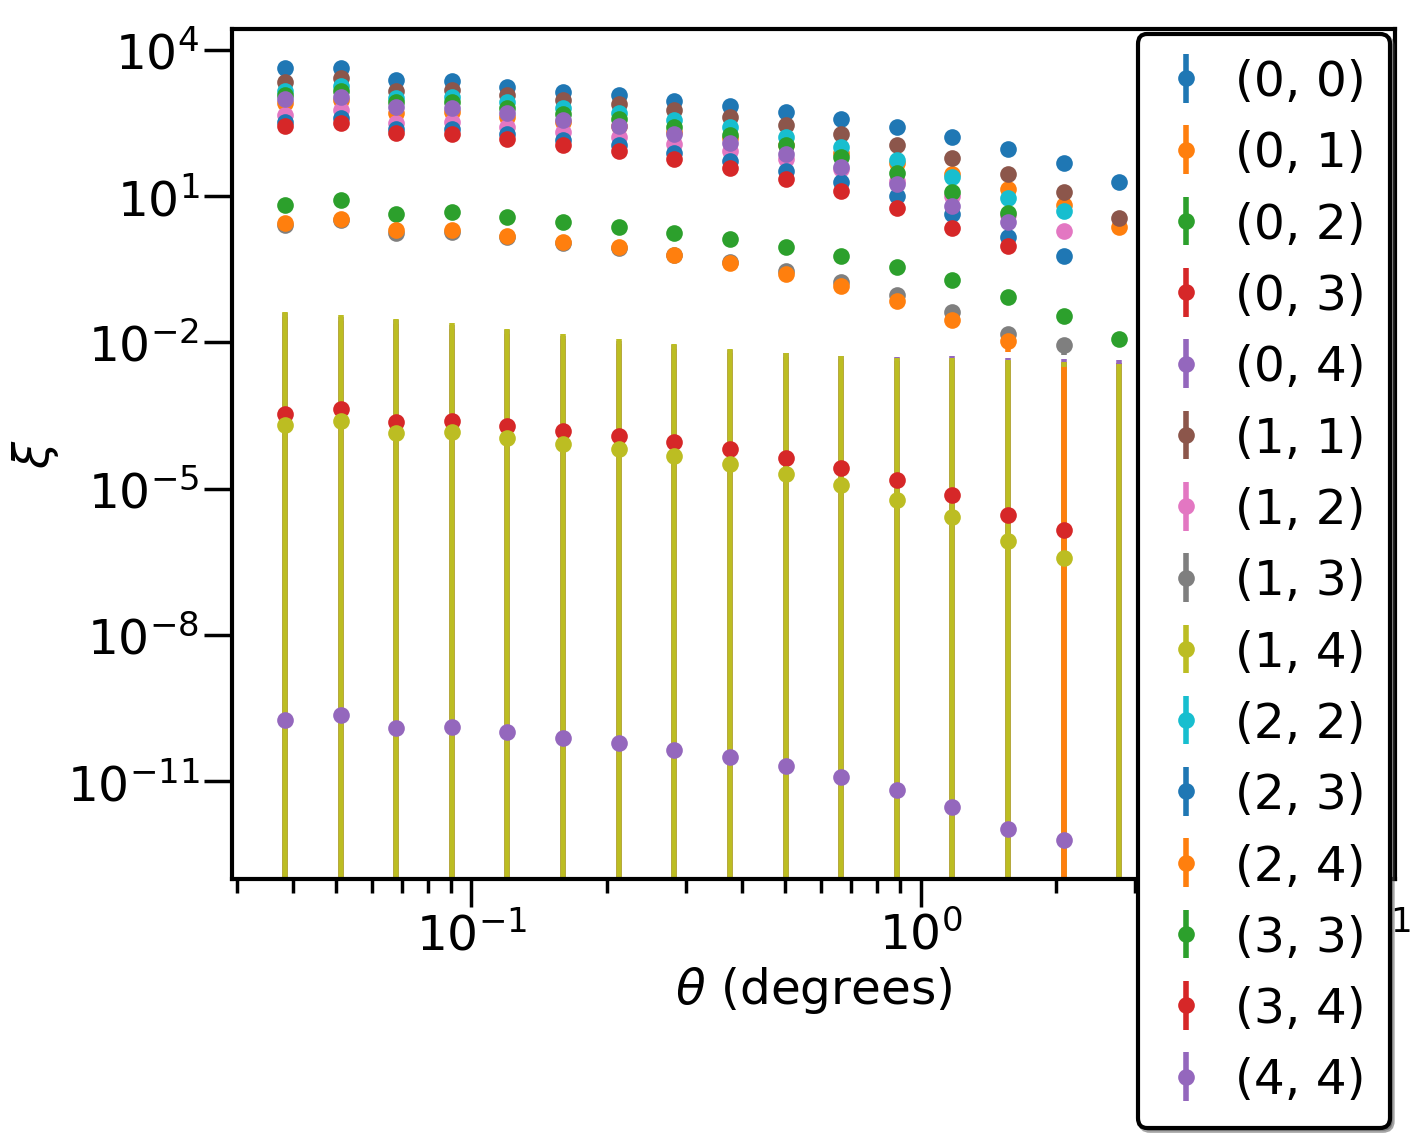

In [221]:
for i in np.arange(nbins):
    for j in np.arange(i,nbins):
        errorbar(thb,xiWggl['xi'][corr_gg][m1m2_gg][(i,j)].compute(),np.sqrt(np.diag(xiWggl['cov'][corr_ggl+corr_ggl][m1m2+m1m2][(i,j,i,j)].compute()['final'])),fmt='o',label=(i,j))
xscale('log')
yscale('log')
xlabel(r'$\theta$ (degrees)')
ylabel(r'$\xi$')
legend()

In [222]:
nbins=5

/usr/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


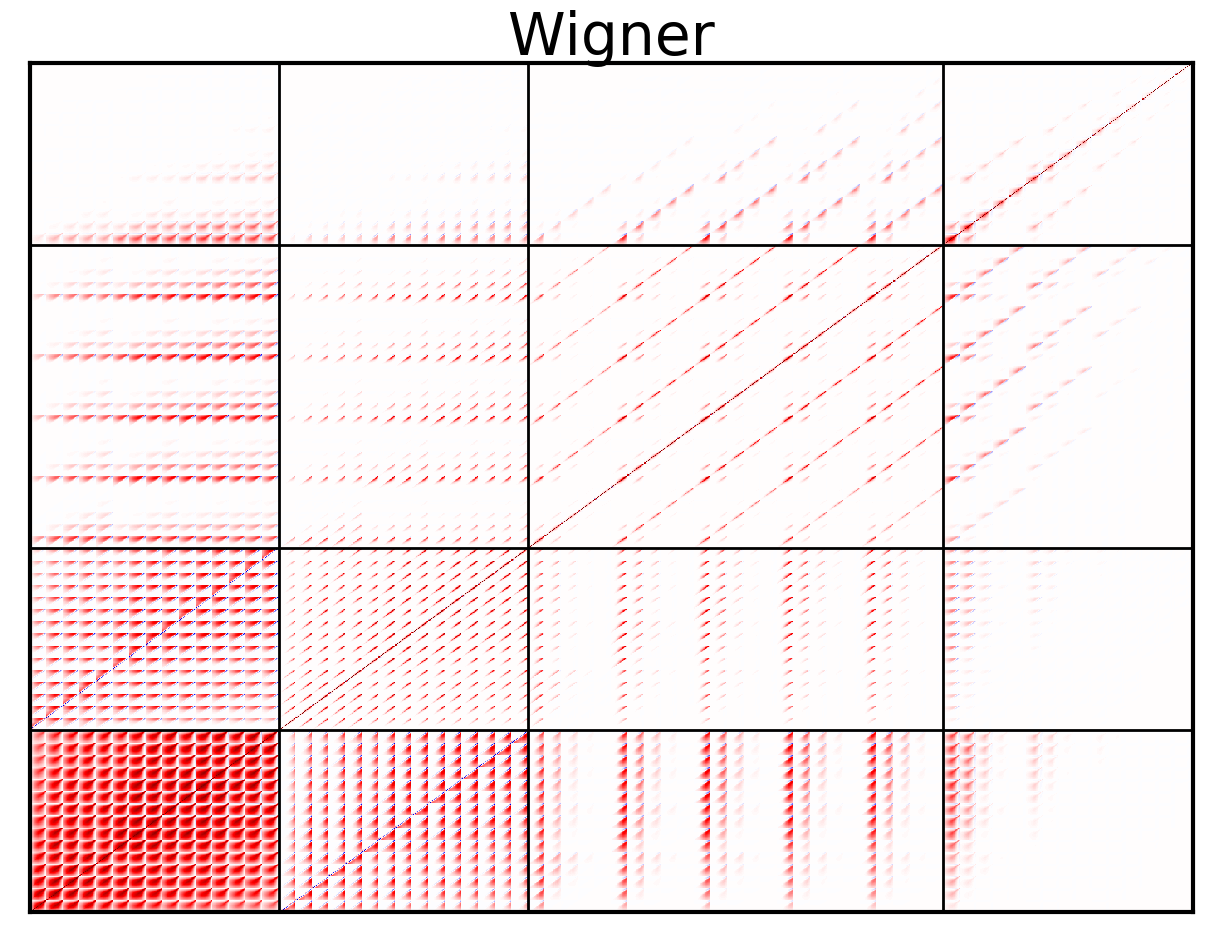

In [223]:
cc=XI_W.cov_utils
corrW=cc.corr_matrix(xiW_ggl['cov'])
pcolor(corrW,vmin=-1,vmax=1,cmap='seismic')
# xlabel(r'$\theta$ (degrees)')
# ylabel(r'$\theta$ (degrees)')
x1=20.*nbins*(nbins+1)/2.
x2=20.*nbins*nbins
hlines(x1,0,len(corrW),lw=2)
vlines(x1,0,len(corrW),lw=2)
hlines(x1*2,0,len(corrW),lw=2)
vlines(x1*2,0,len(corrW),lw=2)
hlines(x1*2+x2,0,len(corrW),lw=2)
vlines(x1*2+x2,0,len(corrW),lw=2)
title('Wigner')
xticks([])
yticks([])
show()
# corrL=cc.corr_matrix(clL['cov'])
# pcolor(corrL,vmin=-1,vmax=1,cmap='seismic')

In [224]:
import healpy as hp
hp.nside2npix(1024)

12582912